In [19]:
import torch
from torch import nn
import torchvision

import Utils

In [20]:
BATCH_SIZE = 128
IMAGE_CHANNEL = 1
X_DIM = 28
LATENT_DIM = 100
G_HIDDEN = 128
D_HIDDEN = 128
EPOCH_NUM = 250
NUM_CLASSES = 10
lr_d = 0.0001
lr_g = 0.0001

In [21]:
device = Utils.get_device()
dataloader = Utils.get_loader(torchvision.datasets.FashionMNIST, X_DIM, BATCH_SIZE)

Using device: cuda
Data loaded


## Sample images from the dataset

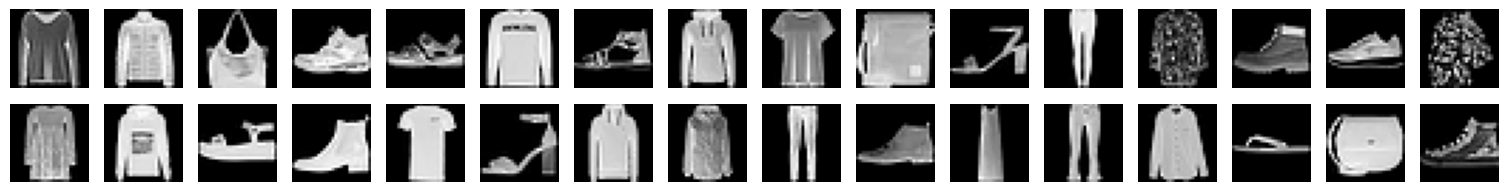

In [22]:
Utils.plot_real(dataloader)

## Model Architecture and Configuration

In [23]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0., 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [24]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(NUM_CLASSES, NUM_CLASSES)
        self.main = nn.Sequential(
            # input layer
            nn.ConvTranspose2d(LATENT_DIM + NUM_CLASSES, G_HIDDEN * 4, kernel_size=7, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 4),
            nn.ReLU(inplace=True),  # shape: (G_HIDDEN * 8, 7, 7)
            # 1st layer
            nn.ConvTranspose2d(G_HIDDEN * 4, G_HIDDEN * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 2),
            nn.ReLU(inplace=True),  # shape: (G_HIDDEN * 2, 14, 14)
            # 2nd layer
            nn.ConvTranspose2d(G_HIDDEN * 2, G_HIDDEN, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(G_HIDDEN),
            nn.ReLU(inplace=True),  # shape: (G_HIDDEN, 28, 28)
            # output layer
            nn.Conv2d(G_HIDDEN, IMAGE_CHANNEL, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Tanh()  # shape: (IMAGE_CHANNEL, 28, 28)
        )   
    
    def forward(self, z, labels):
        label_emb = self.label_emb(labels).unsqueeze(2).unsqueeze(3)  # (batch_size, NUM_CLASSES, 1, 1) 
        x = torch.cat([z, label_emb], dim=1) 
        return self.main(x)

In [25]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(NUM_CLASSES, NUM_CLASSES)
        self.main = nn.Sequential(
            # 1st layer
            nn.Conv2d(IMAGE_CHANNEL + NUM_CLASSES, D_HIDDEN, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),  # shape: (D_HIDDEN, 14, 14)
            # 2nd layer
            nn.Conv2d(D_HIDDEN, D_HIDDEN * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 2),
            nn.LeakyReLU(0.2, inplace=True),  # shape: (D_HIDDEN * 2, 7, 7)
            # 3rd layer
            nn.Conv2d(D_HIDDEN * 2, D_HIDDEN * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 4),
            nn.LeakyReLU(0.2, inplace=True),  # shape: (D_HIDDEN * 4, 3, 3)
            # output layer
            nn.Conv2d(D_HIDDEN * 4, 1, kernel_size=3, stride=1, padding=0, bias=False)
            # shape: (1, 1, 1)
        )

    def forward(self, img, labels):
        label_emb = self.label_emb(labels).unsqueeze(2).unsqueeze(3)
        label_emb = label_emb.expand(-1, -1, X_DIM, X_DIM)
        x = torch.cat([img, label_emb], dim=1)
        return self.main(x).view(-1, 1).squeeze(1)

In [26]:
netG = Generator().to(device)
netG.apply(weights_init)
print('Number of parameters in the generator:', Utils.get_n_params(netG))

netD = Discriminator().to(device)
netD.apply(weights_init)
print('Number of parameters in the discriminator:', Utils.get_n_params(netD))

criterion = nn.BCEWithLogitsLoss()
viz_noise = torch.randn(BATCH_SIZE, LATENT_DIM, 1, 1, device=device)
viz_labels = torch.randint(0, NUM_CLASSES, (BATCH_SIZE,), device=device)

optimizerD = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(0.5, 0.999))

Number of parameters in the generator: 5384164
Number of parameters in the discriminator: 2650212


## Training loop

[1/250][150/469]	Loss_D: 1.1917	Loss_G: 1.5834	D(x): 0.8520	D(G(z)): 0.0338 / -1.2887
[1/250][300/469]	Loss_D: 0.8885	Loss_G: 0.9845	D(x): 0.6089	D(G(z)): -0.9025 / -0.4385
[1/250][450/469]	Loss_D: 0.7283	Loss_G: 1.0623	D(x): 0.5244	D(G(z)): -1.6374 / -0.5434
[2/250][150/469]	Loss_D: 0.8973	Loss_G: 1.5924	D(x): 1.1039	D(G(z)): -0.5927 / -1.2962
[2/250][300/469]	Loss_D: 0.9180	Loss_G: 1.8873	D(x): 1.7174	D(G(z)): -0.1734 / -1.6743
[2/250][450/469]	Loss_D: 1.0635	Loss_G: 1.8253	D(x): 1.2221	D(G(z)): -0.0262 / -1.6091
[3/250][150/469]	Loss_D: 0.9538	Loss_G: 1.1592	D(x): 0.5198	D(G(z)): -0.8832 / -0.6885
[3/250][300/469]	Loss_D: 0.9963	Loss_G: 0.8846	D(x): 0.1787	D(G(z)): -1.2203 / -0.2333
[3/250][450/469]	Loss_D: 0.8873	Loss_G: 1.0426	D(x): 0.6259	D(G(z)): -1.1396 / -0.4861
[4/250][150/469]	Loss_D: 0.9668	Loss_G: 2.2522	D(x): 1.6544	D(G(z)): 0.0057 / -2.0970
[4/250][300/469]	Loss_D: 1.1514	Loss_G: 1.6471	D(x): 1.1393	D(G(z)): -0.1272 / -1.3618
[4/250][450/469]	Loss_D: 1.0247	Loss_G: 1.167

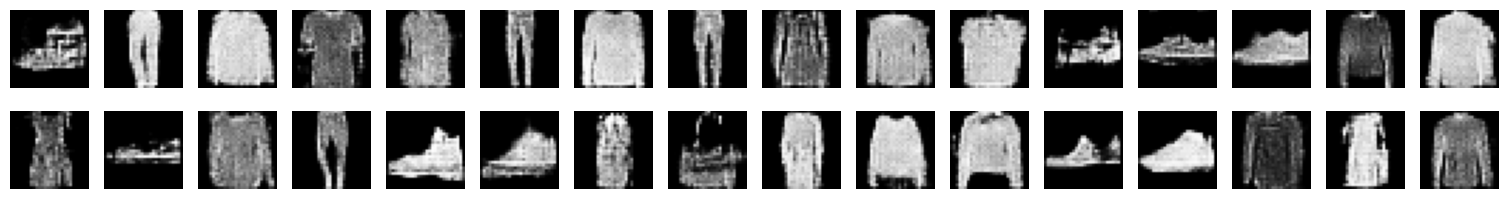

[6/250][150/469]	Loss_D: 0.9558	Loss_G: 1.4727	D(x): 1.0728	D(G(z)): -0.4371 / -1.1528
[6/250][300/469]	Loss_D: 0.8802	Loss_G: 1.5077	D(x): 0.8678	D(G(z)): -0.6674 / -1.2096
[6/250][450/469]	Loss_D: 0.9644	Loss_G: 1.2943	D(x): 0.4184	D(G(z)): -0.9826 / -0.8942
[7/250][150/469]	Loss_D: 1.1231	Loss_G: 1.5428	D(x): 0.6629	D(G(z)): -0.2491 / -1.2407
[7/250][300/469]	Loss_D: 1.0384	Loss_G: 1.7306	D(x): 1.0189	D(G(z)): -0.2350 / -1.4810
[7/250][450/469]	Loss_D: 1.1380	Loss_G: 1.3300	D(x): 0.6418	D(G(z)): -0.2846 / -0.9613
[8/250][150/469]	Loss_D: 1.1074	Loss_G: 0.9390	D(x): 0.0529	D(G(z)): -1.1277 / -0.3486
[8/250][300/469]	Loss_D: 1.0143	Loss_G: 1.2827	D(x): 0.7020	D(G(z)): -0.5808 / -0.8970
[8/250][450/469]	Loss_D: 1.0052	Loss_G: 1.2951	D(x): 0.5802	D(G(z)): -0.7476 / -0.8976
[9/250][150/469]	Loss_D: 1.0567	Loss_G: 0.9754	D(x): 0.0672	D(G(z)): -1.2278 / -0.3984
[9/250][300/469]	Loss_D: 1.0476	Loss_G: 1.6697	D(x): 0.9592	D(G(z)): -0.2452 / -1.4021
[9/250][450/469]	Loss_D: 0.8671	Loss_G: 1.4

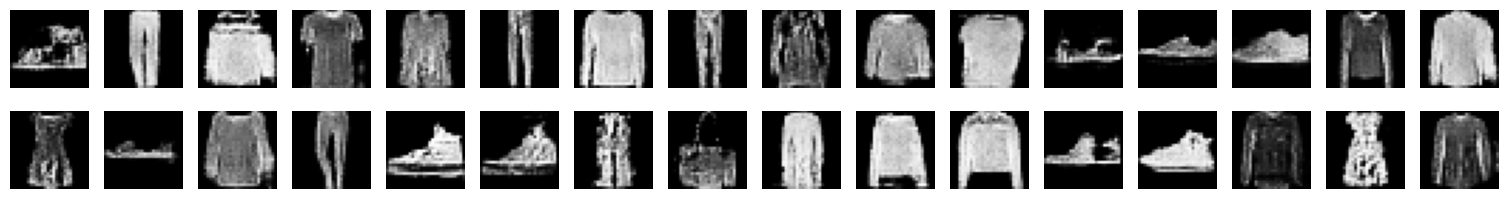

[11/250][150/469]	Loss_D: 0.9455	Loss_G: 1.5228	D(x): 0.7714	D(G(z)): -0.5764 / -1.2128
[11/250][300/469]	Loss_D: 0.9316	Loss_G: 1.1345	D(x): 0.3856	D(G(z)): -1.1623 / -0.6596
[11/250][450/469]	Loss_D: 0.9265	Loss_G: 1.7600	D(x): 1.0670	D(G(z)): -0.5294 / -1.5122
[12/250][150/469]	Loss_D: 1.0072	Loss_G: 1.2261	D(x): 0.4756	D(G(z)): -0.8733 / -0.7952
[12/250][300/469]	Loss_D: 0.9027	Loss_G: 1.4357	D(x): 0.5969	D(G(z)): -0.9644 / -1.0885
[12/250][450/469]	Loss_D: 1.0321	Loss_G: 1.1848	D(x): 0.6171	D(G(z)): -0.5642 / -0.7360
[13/250][150/469]	Loss_D: 1.0370	Loss_G: 1.1338	D(x): 0.1316	D(G(z)): -1.2352 / -0.6409
[13/250][300/469]	Loss_D: 1.0730	Loss_G: 0.9172	D(x): -0.0549	D(G(z)): -1.3249 / -0.2999
[13/250][450/469]	Loss_D: 0.9197	Loss_G: 1.8728	D(x): 1.3353	D(G(z)): -0.2980 / -1.6478
[14/250][150/469]	Loss_D: 0.9723	Loss_G: 1.9668	D(x): 0.8907	D(G(z)): -0.5163 / -1.7604
[14/250][300/469]	Loss_D: 0.9093	Loss_G: 1.2109	D(x): 0.2266	D(G(z)): -1.3944 / -0.7733
[14/250][450/469]	Loss_D: 1.051

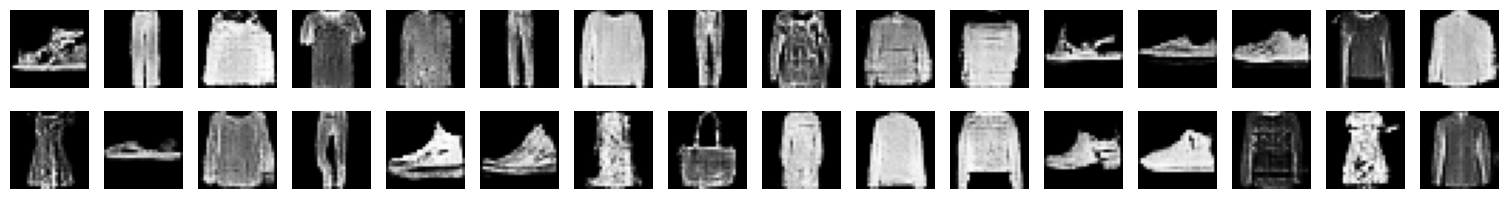

[16/250][150/469]	Loss_D: 0.9663	Loss_G: 1.1683	D(x): 0.4780	D(G(z)): -0.8674 / -0.7325
[16/250][300/469]	Loss_D: 0.9339	Loss_G: 1.8751	D(x): 1.3151	D(G(z)): -0.2845 / -1.6749
[16/250][450/469]	Loss_D: 1.1276	Loss_G: 1.0662	D(x): -0.0062	D(G(z)): -1.0463 / -0.5212
[17/250][150/469]	Loss_D: 0.9095	Loss_G: 1.8145	D(x): 1.3996	D(G(z)): -0.3386 / -1.5816
[17/250][300/469]	Loss_D: 0.9019	Loss_G: 1.6266	D(x): 0.7089	D(G(z)): -0.8868 / -1.3549
[17/250][450/469]	Loss_D: 0.9950	Loss_G: 1.1354	D(x): 0.2782	D(G(z)): -1.1403 / -0.6635
[18/250][150/469]	Loss_D: 0.9167	Loss_G: 1.0004	D(x): 0.3907	D(G(z)): -1.1975 / -0.4591
[18/250][300/469]	Loss_D: 0.8888	Loss_G: 1.0770	D(x): 0.4218	D(G(z)): -1.2452 / -0.5698
[18/250][450/469]	Loss_D: 0.8929	Loss_G: 1.6114	D(x): 0.6466	D(G(z)): -1.0584 / -1.3065
[19/250][150/469]	Loss_D: 1.0788	Loss_G: 0.9171	D(x): 0.0275	D(G(z)): -1.2942 / -0.2943
[19/250][300/469]	Loss_D: 0.9144	Loss_G: 1.5616	D(x): 0.6522	D(G(z)): -0.8195 / -1.2720
[19/250][450/469]	Loss_D: 0.936

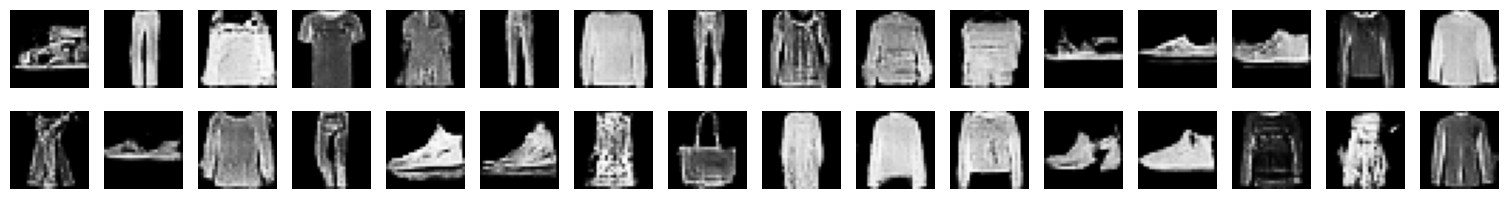

[21/250][150/469]	Loss_D: 0.9175	Loss_G: 1.4358	D(x): 0.2865	D(G(z)): -1.4203 / -1.0958
[21/250][300/469]	Loss_D: 0.8070	Loss_G: 2.0884	D(x): 1.3375	D(G(z)): -0.7601 / -1.9115
[21/250][450/469]	Loss_D: 0.8681	Loss_G: 1.9238	D(x): 1.5505	D(G(z)): -0.3947 / -1.7142
[22/250][150/469]	Loss_D: 0.9817	Loss_G: 2.2673	D(x): 1.4930	D(G(z)): -0.1181 / -2.1310
[22/250][300/469]	Loss_D: 0.8364	Loss_G: 1.6740	D(x): 1.3671	D(G(z)): -0.5341 / -1.4120
[22/250][450/469]	Loss_D: 0.9408	Loss_G: 1.7740	D(x): 1.0405	D(G(z)): -0.5529 / -1.5374
[23/250][150/469]	Loss_D: 0.9744	Loss_G: 1.4483	D(x): 0.4489	D(G(z)): -1.0073 / -1.0941
[23/250][300/469]	Loss_D: 1.1098	Loss_G: 1.9112	D(x): 1.4166	D(G(z)): 0.0313 / -1.6765
[23/250][450/469]	Loss_D: 1.0549	Loss_G: 1.0945	D(x): -0.1093	D(G(z)): -1.7630 / -0.5711
[24/250][150/469]	Loss_D: 0.8177	Loss_G: 1.4939	D(x): 0.6381	D(G(z)): -1.2952 / -1.1545
[24/250][300/469]	Loss_D: 0.9270	Loss_G: 1.2431	D(x): 0.1498	D(G(z)): -1.6810 / -0.8081
[24/250][450/469]	Loss_D: 0.8660

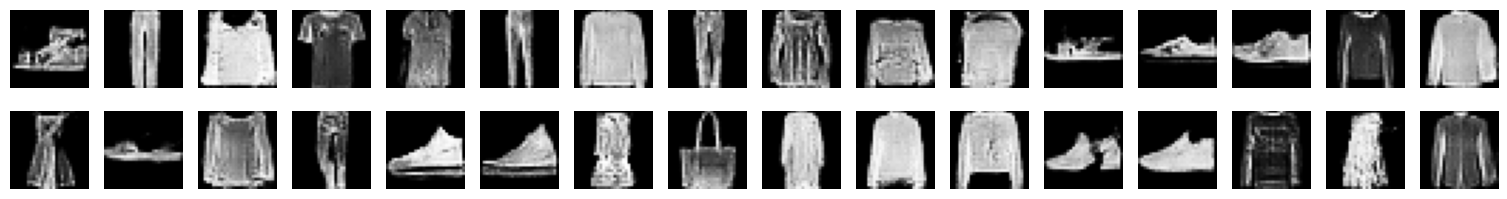

[26/250][150/469]	Loss_D: 0.7909	Loss_G: 1.8029	D(x): 0.8834	D(G(z)): -1.0349 / -1.5721
[26/250][300/469]	Loss_D: 0.9734	Loss_G: 1.6106	D(x): 0.8208	D(G(z)): -0.6331 / -1.3224
[26/250][450/469]	Loss_D: 1.0568	Loss_G: 1.0111	D(x): 0.1186	D(G(z)): -1.1424 / -0.4418
[27/250][150/469]	Loss_D: 0.8433	Loss_G: 1.4226	D(x): 0.5433	D(G(z)): -1.4082 / -1.0677
[27/250][300/469]	Loss_D: 0.7895	Loss_G: 1.5910	D(x): 0.6879	D(G(z)): -1.3747 / -1.3008
[27/250][450/469]	Loss_D: 0.7612	Loss_G: 1.5848	D(x): 0.9347	D(G(z)): -1.0571 / -1.2978
[28/250][150/469]	Loss_D: 0.7810	Loss_G: 1.8340	D(x): 1.2384	D(G(z)): -0.7448 / -1.6157
[28/250][300/469]	Loss_D: 0.8720	Loss_G: 1.4695	D(x): 0.9915	D(G(z)): -0.6826 / -1.1426
[28/250][450/469]	Loss_D: 0.8878	Loss_G: 1.5844	D(x): 0.6496	D(G(z)): -1.2143 / -1.2853
[29/250][150/469]	Loss_D: 0.9874	Loss_G: 1.5577	D(x): 0.4641	D(G(z)): -1.0523 / -1.2223
[29/250][300/469]	Loss_D: 0.8164	Loss_G: 1.4745	D(x): 0.7267	D(G(z)): -1.2069 / -1.1418
[29/250][450/469]	Loss_D: 0.8784

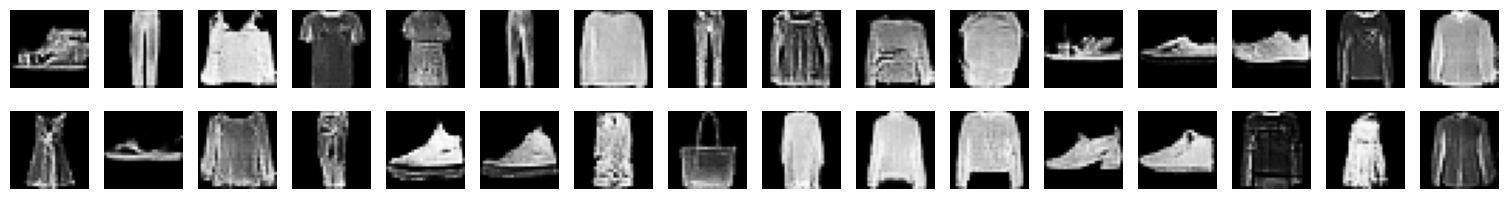

[31/250][150/469]	Loss_D: 0.7989	Loss_G: 1.4931	D(x): 0.8899	D(G(z)): -1.1442 / -1.1712
[31/250][300/469]	Loss_D: 0.8750	Loss_G: 1.9489	D(x): 0.9617	D(G(z)): -0.8017 / -1.7455
[31/250][450/469]	Loss_D: 0.8181	Loss_G: 2.2230	D(x): 1.6055	D(G(z)): -0.5508 / -2.0750
[32/250][150/469]	Loss_D: 1.1062	Loss_G: 2.4766	D(x): 1.8351	D(G(z)): 0.1613 / -2.3632
[32/250][300/469]	Loss_D: 0.7221	Loss_G: 1.5732	D(x): 1.0535	D(G(z)): -1.2185 / -1.2615
[32/250][450/469]	Loss_D: 0.8743	Loss_G: 1.1355	D(x): 0.2259	D(G(z)): -2.1217 / -0.6160
[33/250][150/469]	Loss_D: 0.7802	Loss_G: 1.7470	D(x): 0.9501	D(G(z)): -1.1536 / -1.5003
[33/250][300/469]	Loss_D: 0.7137	Loss_G: 1.6968	D(x): 1.1410	D(G(z)): -1.2633 / -1.4202
[33/250][450/469]	Loss_D: 0.9225	Loss_G: 1.3879	D(x): 0.1490	D(G(z)): -1.8258 / -0.9964
[34/250][150/469]	Loss_D: 0.8962	Loss_G: 2.9326	D(x): 2.5501	D(G(z)): -0.1143 / -2.8507
[34/250][300/469]	Loss_D: 0.6975	Loss_G: 2.5155	D(x): 1.9707	D(G(z)): -0.6417 / -2.4075
[34/250][450/469]	Loss_D: 0.7387	

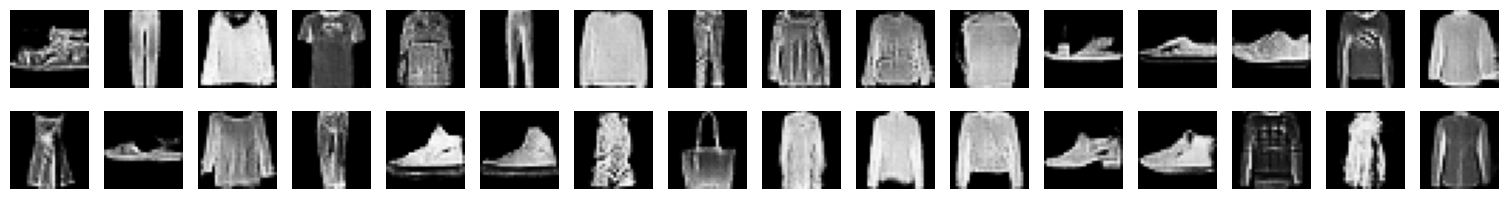

[36/250][150/469]	Loss_D: 0.7097	Loss_G: 1.6123	D(x): 1.0695	D(G(z)): -1.2269 / -1.3110
[36/250][300/469]	Loss_D: 0.7431	Loss_G: 1.9739	D(x): 1.3707	D(G(z)): -0.9488 / -1.7727
[36/250][450/469]	Loss_D: 0.7945	Loss_G: 2.1010	D(x): 1.3778	D(G(z)): -0.6842 / -1.9322
[37/250][150/469]	Loss_D: 0.7424	Loss_G: 1.8027	D(x): 0.6954	D(G(z)): -1.6184 / -1.5524
[37/250][300/469]	Loss_D: 0.6339	Loss_G: 2.2942	D(x): 1.3195	D(G(z)): -1.1837 / -2.1604
[37/250][450/469]	Loss_D: 0.8930	Loss_G: 2.5157	D(x): 2.2328	D(G(z)): -0.3376 / -2.3812
[38/250][150/469]	Loss_D: 0.6794	Loss_G: 1.7745	D(x): 1.3546	D(G(z)): -1.2072 / -1.5151
[38/250][300/469]	Loss_D: 0.7907	Loss_G: 1.8586	D(x): 1.0881	D(G(z)): -0.9388 / -1.6435
[38/250][450/469]	Loss_D: 0.7815	Loss_G: 1.7087	D(x): 0.9030	D(G(z)): -1.3852 / -1.4502
[39/250][150/469]	Loss_D: 0.7949	Loss_G: 2.3111	D(x): 1.6628	D(G(z)): -0.7627 / -2.1714
[39/250][300/469]	Loss_D: 0.6427	Loss_G: 2.3412	D(x): 1.8137	D(G(z)): -1.0117 / -2.1994
[39/250][450/469]	Loss_D: 0.7702

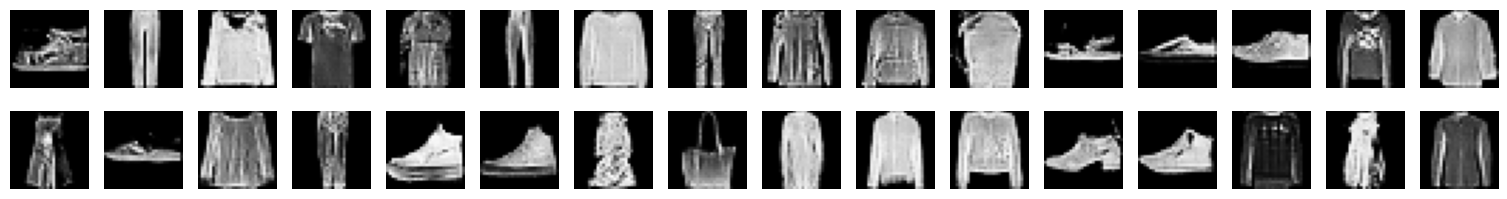

[41/250][150/469]	Loss_D: 0.7364	Loss_G: 1.8225	D(x): 0.7137	D(G(z)): -1.8042 / -1.5790
[41/250][300/469]	Loss_D: 0.4565	Loss_G: 1.7226	D(x): 1.5428	D(G(z)): -2.0904 / -1.4372
[41/250][450/469]	Loss_D: 0.8837	Loss_G: 2.5477	D(x): 1.9021	D(G(z)): -0.4711 / -2.4190
[42/250][150/469]	Loss_D: 0.7154	Loss_G: 1.7699	D(x): 0.6808	D(G(z)): -2.1144 / -1.4860
[42/250][300/469]	Loss_D: 0.5295	Loss_G: 2.3125	D(x): 1.8749	D(G(z)): -1.3724 / -2.1681
[42/250][450/469]	Loss_D: 0.6294	Loss_G: 2.6185	D(x): 1.8442	D(G(z)): -1.1101 / -2.5113
[43/250][150/469]	Loss_D: 0.6180	Loss_G: 2.0171	D(x): 1.3743	D(G(z)): -1.3521 / -1.8174
[43/250][300/469]	Loss_D: 0.6361	Loss_G: 1.6493	D(x): 0.7747	D(G(z)): -2.2821 / -1.3157
[43/250][450/469]	Loss_D: 0.8541	Loss_G: 1.7887	D(x): 0.5092	D(G(z)): -1.7392 / -1.4868
[44/250][150/469]	Loss_D: 0.6661	Loss_G: 2.2860	D(x): 1.1104	D(G(z)): -1.5508 / -2.1330
[44/250][300/469]	Loss_D: 0.6746	Loss_G: 1.7426	D(x): 0.6868	D(G(z)): -2.1594 / -1.4716
[44/250][450/469]	Loss_D: 0.6131

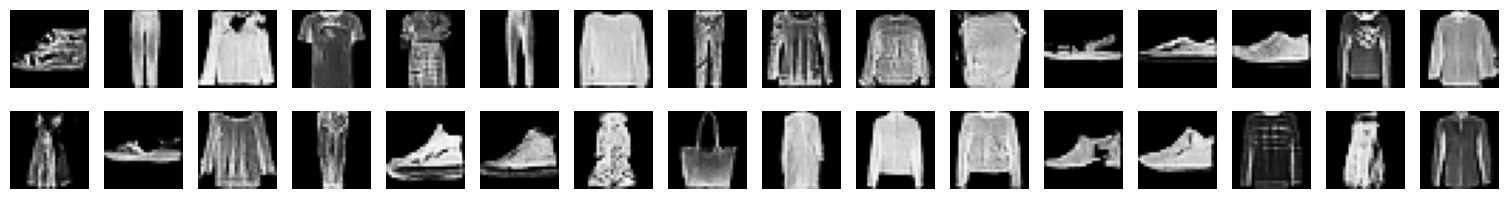

[46/250][150/469]	Loss_D: 0.7248	Loss_G: 3.0414	D(x): 1.6679	D(G(z)): -0.7792 / -2.9730
[46/250][300/469]	Loss_D: 0.6822	Loss_G: 2.0788	D(x): 1.5981	D(G(z)): -1.0924 / -1.8857
[46/250][450/469]	Loss_D: 0.8011	Loss_G: 2.6032	D(x): 1.7737	D(G(z)): -0.7135 / -2.4823
[47/250][150/469]	Loss_D: 0.4932	Loss_G: 2.3868	D(x): 2.1555	D(G(z)): -1.2980 / -2.2518
[47/250][300/469]	Loss_D: 0.6080	Loss_G: 2.0106	D(x): 1.5507	D(G(z)): -1.2566 / -1.8248
[47/250][450/469]	Loss_D: 0.6414	Loss_G: 2.0473	D(x): 1.6984	D(G(z)): -1.0614 / -1.8629
[48/250][150/469]	Loss_D: 0.6228	Loss_G: 1.9211	D(x): 1.0390	D(G(z)): -1.9474 / -1.6876
[48/250][300/469]	Loss_D: 0.5043	Loss_G: 2.7889	D(x): 1.8381	D(G(z)): -1.5421 / -2.6991
[48/250][450/469]	Loss_D: 0.5082	Loss_G: 2.7523	D(x): 2.3338	D(G(z)): -1.2301 / -2.6635
[49/250][150/469]	Loss_D: 0.6117	Loss_G: 2.8762	D(x): 2.0005	D(G(z)): -0.9840 / -2.7925
[49/250][300/469]	Loss_D: 0.7274	Loss_G: 1.9863	D(x): 1.6402	D(G(z)): -0.9397 / -1.7738
[49/250][450/469]	Loss_D: 0.6932

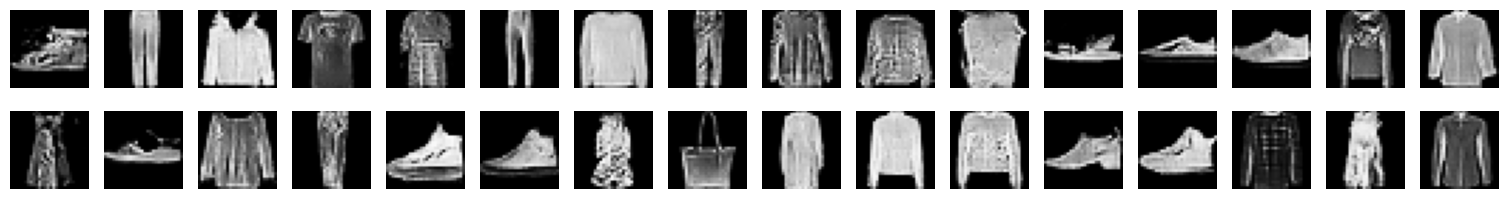

[51/250][150/469]	Loss_D: 0.8879	Loss_G: 1.2231	D(x): 0.3915	D(G(z)): -2.0712 / -0.6392
[51/250][300/469]	Loss_D: 0.5445	Loss_G: 3.2943	D(x): 2.8299	D(G(z)): -0.9739 / -3.2393
[51/250][450/469]	Loss_D: 0.5952	Loss_G: 1.8197	D(x): 1.0359	D(G(z)): -2.2118 / -1.5412
[52/250][150/469]	Loss_D: 0.5957	Loss_G: 2.1899	D(x): 1.5468	D(G(z)): -1.4326 / -2.0063
[52/250][300/469]	Loss_D: 0.8651	Loss_G: 2.8963	D(x): 1.8749	D(G(z)): -0.5174 / -2.8096
[52/250][450/469]	Loss_D: 0.6388	Loss_G: 3.1482	D(x): 2.1338	D(G(z)): -0.9198 / -3.0780
[53/250][150/469]	Loss_D: 0.6321	Loss_G: 1.9862	D(x): 0.6515	D(G(z)): -3.0270 / -1.7269
[53/250][300/469]	Loss_D: 0.8247	Loss_G: 1.2678	D(x): 0.2920	D(G(z)): -2.7149 / -0.7658
[53/250][450/469]	Loss_D: 0.4426	Loss_G: 2.7539	D(x): 1.8442	D(G(z)): -1.8351 / -2.6568
[54/250][150/469]	Loss_D: 0.5443	Loss_G: 1.8637	D(x): 1.5338	D(G(z)): -1.6259 / -1.6179
[54/250][300/469]	Loss_D: 0.5948	Loss_G: 1.8298	D(x): 0.9924	D(G(z)): -2.3516 / -1.5617
[54/250][450/469]	Loss_D: 0.6308

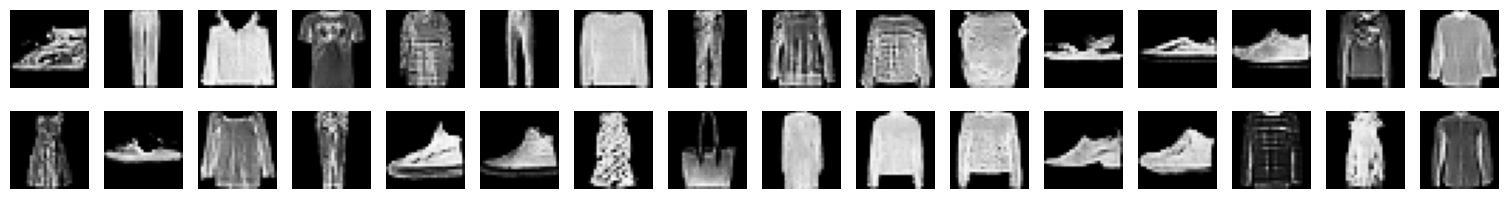

[56/250][150/469]	Loss_D: 0.5502	Loss_G: 2.0540	D(x): 1.0391	D(G(z)): -2.4430 / -1.8321
[56/250][300/469]	Loss_D: 0.6054	Loss_G: 2.5009	D(x): 1.4055	D(G(z)): -1.6310 / -2.3770
[56/250][450/469]	Loss_D: 0.7498	Loss_G: 1.2675	D(x): 0.3775	D(G(z)): -2.7558 / -0.6809
[57/250][150/469]	Loss_D: 0.6158	Loss_G: 2.4870	D(x): 1.4808	D(G(z)): -1.5415 / -2.3472
[57/250][300/469]	Loss_D: 0.6611	Loss_G: 3.2085	D(x): 2.3142	D(G(z)): -0.9760 / -3.1325
[57/250][450/469]	Loss_D: 0.4939	Loss_G: 1.5245	D(x): 1.2955	D(G(z)): -2.3463 / -1.1836
[58/250][150/469]	Loss_D: 0.5413	Loss_G: 2.9804	D(x): 2.1465	D(G(z)): -1.3368 / -2.9014
[58/250][300/469]	Loss_D: 0.5677	Loss_G: 1.9017	D(x): 1.1461	D(G(z)): -2.5204 / -1.6142
[58/250][450/469]	Loss_D: 0.5105	Loss_G: 1.7546	D(x): 1.1883	D(G(z)): -2.1320 / -1.4733
[59/250][150/469]	Loss_D: 0.4912	Loss_G: 3.0651	D(x): 2.5599	D(G(z)): -1.3427 / -2.9884
[59/250][300/469]	Loss_D: 0.5642	Loss_G: 1.8852	D(x): 0.9016	D(G(z)): -2.6936 / -1.6402
[59/250][450/469]	Loss_D: 0.6042

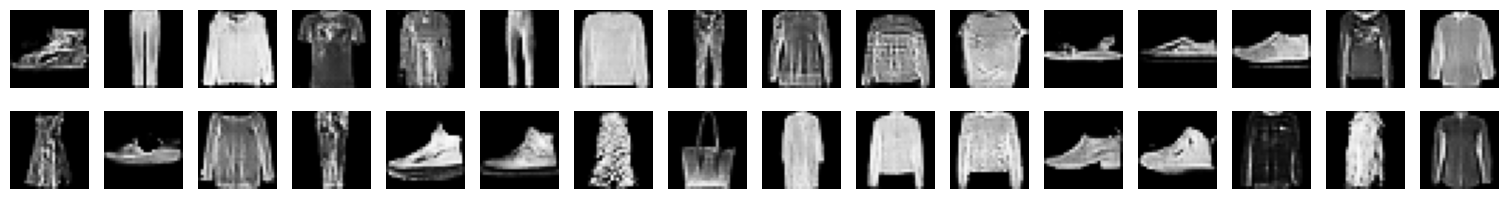

[61/250][150/469]	Loss_D: 0.5575	Loss_G: 2.7145	D(x): 1.3109	D(G(z)): -2.4031 / -2.5616
[61/250][300/469]	Loss_D: 0.4237	Loss_G: 2.3901	D(x): 1.3948	D(G(z)): -2.8060 / -2.2343
[61/250][450/469]	Loss_D: 0.4930	Loss_G: 3.1180	D(x): 1.6718	D(G(z)): -2.4467 / -3.0402
[62/250][150/469]	Loss_D: 0.4393	Loss_G: 2.1153	D(x): 1.6796	D(G(z)): -2.3820 / -1.8965
[62/250][300/469]	Loss_D: 0.4826	Loss_G: 2.3848	D(x): 1.4362	D(G(z)): -2.4323 / -2.2082
[62/250][450/469]	Loss_D: 0.5944	Loss_G: 3.0307	D(x): 2.1916	D(G(z)): -1.2315 / -2.9553
[63/250][150/469]	Loss_D: 0.5176	Loss_G: 3.6004	D(x): 2.3286	D(G(z)): -1.4289 / -3.5487
[63/250][300/469]	Loss_D: 0.4669	Loss_G: 3.3939	D(x): 2.7055	D(G(z)): -1.4787 / -3.3340
[63/250][450/469]	Loss_D: 0.3710	Loss_G: 3.6318	D(x): 2.6001	D(G(z)): -1.9825 / -3.5853
[64/250][150/469]	Loss_D: 0.5998	Loss_G: 3.4128	D(x): 2.1665	D(G(z)): -1.2953 / -3.3487
[64/250][300/469]	Loss_D: 0.4168	Loss_G: 3.2713	D(x): 3.0127	D(G(z)): -1.5706 / -3.2140
[64/250][450/469]	Loss_D: 0.5686

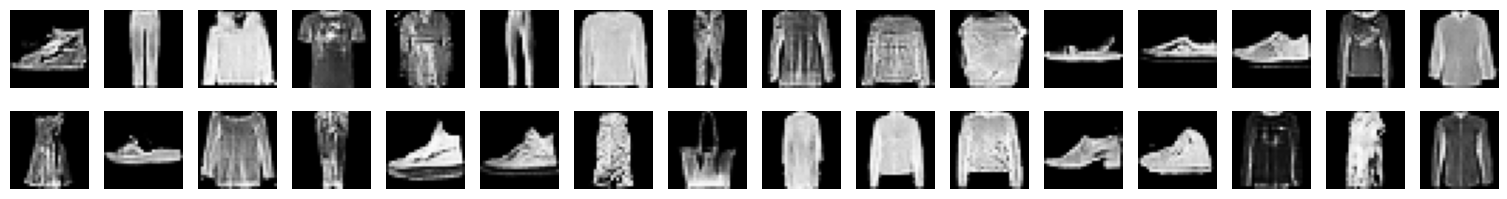

[66/250][150/469]	Loss_D: 0.3837	Loss_G: 2.8540	D(x): 2.0683	D(G(z)): -2.4806 / -2.7470
[66/250][300/469]	Loss_D: 0.3517	Loss_G: 2.4570	D(x): 2.1769	D(G(z)): -2.3308 / -2.3133
[66/250][450/469]	Loss_D: 0.4191	Loss_G: 3.2660	D(x): 2.5998	D(G(z)): -1.7175 / -3.2033
[67/250][150/469]	Loss_D: 0.2995	Loss_G: 3.5205	D(x): 3.1412	D(G(z)): -2.0728 / -3.4717
[67/250][300/469]	Loss_D: 0.4195	Loss_G: 2.9546	D(x): 2.3325	D(G(z)): -1.9240 / -2.8667
[67/250][450/469]	Loss_D: 0.4703	Loss_G: 2.4592	D(x): 1.9947	D(G(z)): -2.0676 / -2.3028
[68/250][150/469]	Loss_D: 0.4094	Loss_G: 2.5416	D(x): 1.6685	D(G(z)): -2.5000 / -2.4143
[68/250][300/469]	Loss_D: 0.5786	Loss_G: 2.4534	D(x): 1.1389	D(G(z)): -3.1358 / -2.1660
[68/250][450/469]	Loss_D: 0.5914	Loss_G: 2.1522	D(x): 1.1868	D(G(z)): -2.1946 / -1.9331
[69/250][150/469]	Loss_D: 0.5019	Loss_G: 4.3731	D(x): 3.0689	D(G(z)): -1.2728 / -4.3451
[69/250][300/469]	Loss_D: 0.6074	Loss_G: 1.4254	D(x): 1.1551	D(G(z)): -1.9711 / -1.0054
[69/250][450/469]	Loss_D: 0.4548

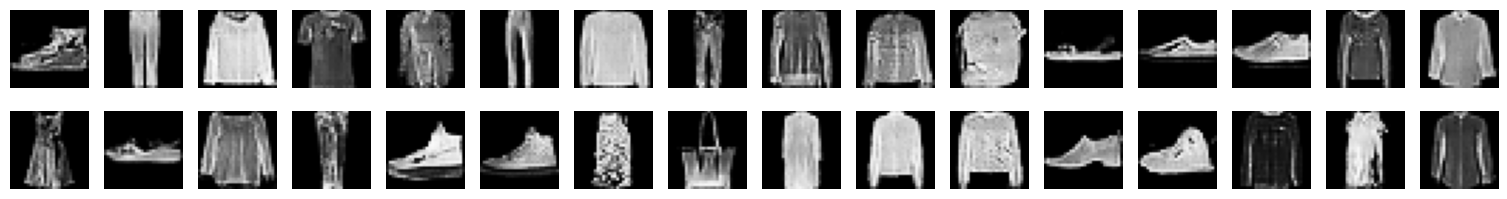

[71/250][150/469]	Loss_D: 0.3107	Loss_G: 3.6858	D(x): 3.7077	D(G(z)): -1.9229 / -3.6445
[71/250][300/469]	Loss_D: 0.3803	Loss_G: 2.5498	D(x): 1.6285	D(G(z)): -3.1050 / -2.3691
[71/250][450/469]	Loss_D: 0.2150	Loss_G: 4.6929	D(x): 2.7000	D(G(z)): -3.3935 / -4.6720
[72/250][150/469]	Loss_D: 0.3623	Loss_G: 3.1461	D(x): 2.9377	D(G(z)): -1.9447 / -3.0756
[72/250][300/469]	Loss_D: 0.4887	Loss_G: 3.8682	D(x): 2.6561	D(G(z)): -1.4478 / -3.8298
[72/250][450/469]	Loss_D: 0.4828	Loss_G: 2.2997	D(x): 1.4786	D(G(z)): -2.5647 / -2.0844
[73/250][150/469]	Loss_D: 0.3243	Loss_G: 2.8960	D(x): 1.8220	D(G(z)): -3.0587 / -2.7858
[73/250][300/469]	Loss_D: 0.3887	Loss_G: 3.1249	D(x): 1.8284	D(G(z)): -3.2866 / -3.0370
[73/250][450/469]	Loss_D: 0.4281	Loss_G: 3.3627	D(x): 2.6685	D(G(z)): -1.6230 / -3.3084
[74/250][150/469]	Loss_D: 0.5096	Loss_G: 3.0535	D(x): 1.5588	D(G(z)): -2.4204 / -2.9508
[74/250][300/469]	Loss_D: 0.4457	Loss_G: 3.8916	D(x): 3.1797	D(G(z)): -1.6700 / -3.8525
[74/250][450/469]	Loss_D: 0.3363

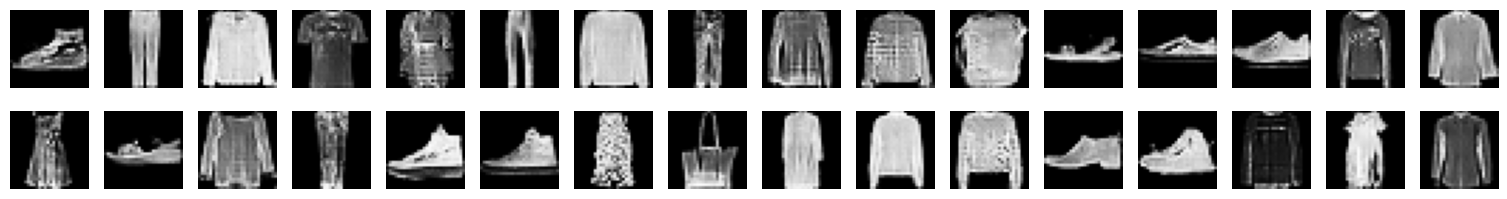

[76/250][150/469]	Loss_D: 0.4589	Loss_G: 2.5735	D(x): 2.1060	D(G(z)): -2.0226 / -2.4361
[76/250][300/469]	Loss_D: 0.3256	Loss_G: 3.1236	D(x): 1.8908	D(G(z)): -3.3234 / -3.0351
[76/250][450/469]	Loss_D: 0.4979	Loss_G: 2.7744	D(x): 1.5427	D(G(z)): -2.3415 / -2.6632
[77/250][150/469]	Loss_D: 0.3729	Loss_G: 3.1155	D(x): 2.6388	D(G(z)): -1.7852 / -3.0517
[77/250][300/469]	Loss_D: 0.4463	Loss_G: 2.2848	D(x): 1.4855	D(G(z)): -2.9288 / -2.0811
[77/250][450/469]	Loss_D: 0.6709	Loss_G: 1.3257	D(x): 0.6549	D(G(z)): -3.0757 / -0.6430
[78/250][150/469]	Loss_D: 0.3390	Loss_G: 3.6488	D(x): 2.8740	D(G(z)): -1.9532 / -3.6061
[78/250][300/469]	Loss_D: 0.2546	Loss_G: 3.9086	D(x): 3.3160	D(G(z)): -2.4230 / -3.8695
[78/250][450/469]	Loss_D: 0.3546	Loss_G: 3.0631	D(x): 1.6564	D(G(z)): -3.7744 / -2.9571
[79/250][150/469]	Loss_D: 0.3697	Loss_G: 3.7623	D(x): 2.2757	D(G(z)): -2.6879 / -3.7149
[79/250][300/469]	Loss_D: 0.5248	Loss_G: 1.7854	D(x): 1.2948	D(G(z)): -2.6078 / -1.4807
[79/250][450/469]	Loss_D: 0.4732

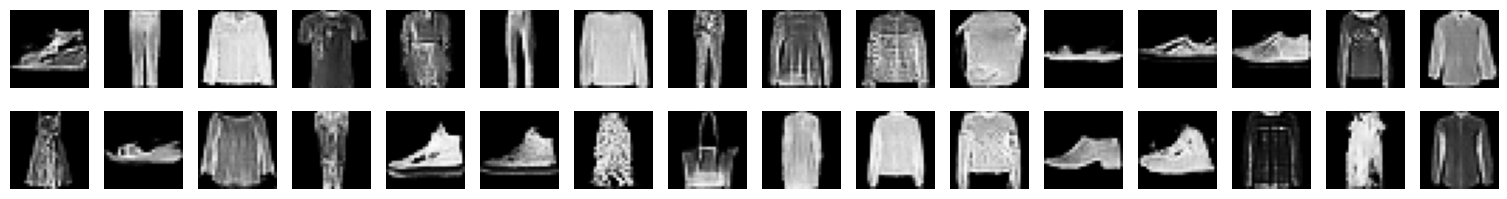

[81/250][150/469]	Loss_D: 0.7344	Loss_G: 1.7911	D(x): 0.3974	D(G(z)): -4.5454 / -1.3656
[81/250][300/469]	Loss_D: 0.2560	Loss_G: 3.8145	D(x): 2.7998	D(G(z)): -2.4476 / -3.7828
[81/250][450/469]	Loss_D: 0.4060	Loss_G: 2.5549	D(x): 1.2938	D(G(z)): -3.7877 / -2.3923
[82/250][150/469]	Loss_D: 0.3349	Loss_G: 2.7954	D(x): 2.2917	D(G(z)): -2.9695 / -2.6642
[82/250][300/469]	Loss_D: 0.2227	Loss_G: 3.8784	D(x): 3.0377	D(G(z)): -3.0017 / -3.8361
[82/250][450/469]	Loss_D: 0.3991	Loss_G: 4.7790	D(x): 3.6712	D(G(z)): -1.6320 / -4.7632
[83/250][150/469]	Loss_D: 0.2115	Loss_G: 4.2744	D(x): 4.1433	D(G(z)): -2.4679 / -4.2468
[83/250][300/469]	Loss_D: 0.2897	Loss_G: 3.8395	D(x): 2.4186	D(G(z)): -3.0860 / -3.7954
[83/250][450/469]	Loss_D: 0.3380	Loss_G: 3.1065	D(x): 2.0671	D(G(z)): -3.5358 / -3.0055
[84/250][150/469]	Loss_D: 0.2899	Loss_G: 4.2339	D(x): 2.8256	D(G(z)): -2.7199 / -4.2070
[84/250][300/469]	Loss_D: 0.3067	Loss_G: 4.0877	D(x): 3.7193	D(G(z)): -1.9385 / -4.0538
[84/250][450/469]	Loss_D: 0.3077

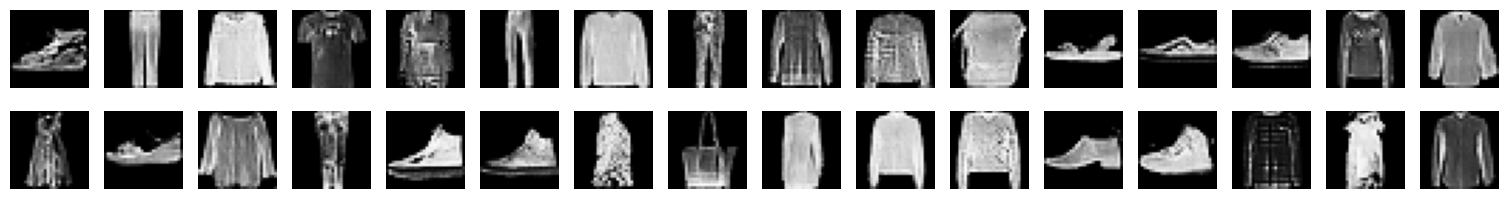

[86/250][150/469]	Loss_D: 0.2953	Loss_G: 4.1707	D(x): 3.0122	D(G(z)): -2.3560 / -4.1435
[86/250][300/469]	Loss_D: 0.4264	Loss_G: 4.0237	D(x): 3.3695	D(G(z)): -1.7420 / -3.9889
[86/250][450/469]	Loss_D: 0.3021	Loss_G: 2.9554	D(x): 2.0630	D(G(z)): -3.4120 / -2.8432
[87/250][150/469]	Loss_D: 0.1845	Loss_G: 3.6181	D(x): 2.7518	D(G(z)): -3.5555 / -3.5670
[87/250][300/469]	Loss_D: 0.2531	Loss_G: 4.1857	D(x): 2.1730	D(G(z)): -4.1414 / -4.1501
[87/250][450/469]	Loss_D: 0.3973	Loss_G: 3.0385	D(x): 1.7950	D(G(z)): -3.6118 / -2.9400
[88/250][150/469]	Loss_D: 0.1606	Loss_G: 4.6638	D(x): 3.3741	D(G(z)): -3.3804 / -4.6439
[88/250][300/469]	Loss_D: 0.3288	Loss_G: 3.5961	D(x): 2.0696	D(G(z)): -3.3994 / -3.5384
[88/250][450/469]	Loss_D: 0.2239	Loss_G: 3.8226	D(x): 2.9368	D(G(z)): -2.9721 / -3.7746
[89/250][150/469]	Loss_D: 0.1691	Loss_G: 4.2650	D(x): 3.3051	D(G(z)): -3.1550 / -4.2415
[89/250][300/469]	Loss_D: 0.2909	Loss_G: 3.7166	D(x): 3.3941	D(G(z)): -2.2913 / -3.6721
[89/250][450/469]	Loss_D: 0.2384

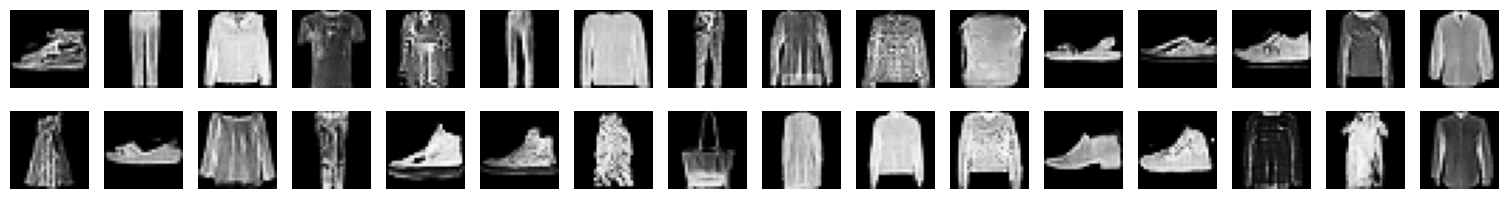

[91/250][150/469]	Loss_D: 0.2030	Loss_G: 3.8773	D(x): 2.5927	D(G(z)): -3.7455 / -3.8294
[91/250][300/469]	Loss_D: 0.2885	Loss_G: 4.0035	D(x): 2.7733	D(G(z)): -2.9037 / -3.9616
[91/250][450/469]	Loss_D: 0.3094	Loss_G: 4.4721	D(x): 3.1649	D(G(z)): -2.3809 / -4.4488
[92/250][150/469]	Loss_D: 0.3117	Loss_G: 3.3779	D(x): 2.0413	D(G(z)): -3.3772 / -3.3131
[92/250][300/469]	Loss_D: 0.2725	Loss_G: 3.3042	D(x): 2.1723	D(G(z)): -3.2518 / -3.2337
[92/250][450/469]	Loss_D: 0.3723	Loss_G: 4.1277	D(x): 3.2656	D(G(z)): -1.7074 / -4.1034
[93/250][150/469]	Loss_D: 0.3339	Loss_G: 4.5207	D(x): 3.8168	D(G(z)): -2.1885 / -4.4986
[93/250][300/469]	Loss_D: 0.3770	Loss_G: 2.9922	D(x): 1.3902	D(G(z)): -4.2446 / -2.8253
[93/250][450/469]	Loss_D: 0.1930	Loss_G: 4.5706	D(x): 3.2611	D(G(z)): -3.0986 / -4.5480
[94/250][150/469]	Loss_D: 0.2624	Loss_G: 3.9062	D(x): 2.3303	D(G(z)): -3.3949 / -3.8653
[94/250][300/469]	Loss_D: 0.4077	Loss_G: 5.3252	D(x): 4.0576	D(G(z)): -1.6866 / -5.3162
[94/250][450/469]	Loss_D: 0.1459

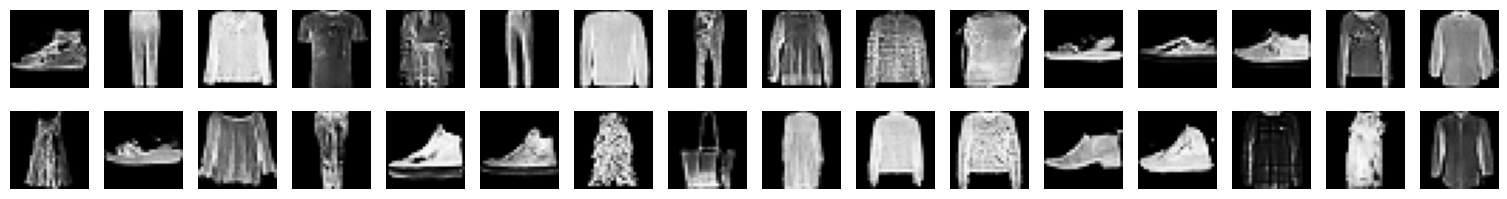

[96/250][150/469]	Loss_D: 0.2724	Loss_G: 4.2833	D(x): 2.9682	D(G(z)): -2.8499 / -4.2434
[96/250][300/469]	Loss_D: 0.2116	Loss_G: 3.5340	D(x): 2.6459	D(G(z)): -3.4260 / -3.4615
[96/250][450/469]	Loss_D: 0.1630	Loss_G: 4.1609	D(x): 4.0117	D(G(z)): -2.8590 / -4.1343
[97/250][150/469]	Loss_D: 0.1704	Loss_G: 4.8016	D(x): 3.5468	D(G(z)): -3.6652 / -4.7822
[97/250][300/469]	Loss_D: 0.2948	Loss_G: 3.4257	D(x): 1.8402	D(G(z)): -5.1139 / -3.3382
[97/250][450/469]	Loss_D: 0.4109	Loss_G: 3.5868	D(x): 1.8383	D(G(z)): -4.3053 / -3.4802
[98/250][150/469]	Loss_D: 0.3240	Loss_G: 4.4916	D(x): 3.7377	D(G(z)): -2.2378 / -4.4591
[98/250][300/469]	Loss_D: 0.2047	Loss_G: 3.5973	D(x): 3.2803	D(G(z)): -2.9694 / -3.5474
[98/250][450/469]	Loss_D: 0.2044	Loss_G: 3.9883	D(x): 2.5338	D(G(z)): -3.5847 / -3.9538
[99/250][150/469]	Loss_D: 0.1037	Loss_G: 4.5284	D(x): 3.5943	D(G(z)): -4.0864 / -4.5029
[99/250][300/469]	Loss_D: 0.2837	Loss_G: 3.4304	D(x): 2.4108	D(G(z)): -3.3709 / -3.3565
[99/250][450/469]	Loss_D: 0.3075

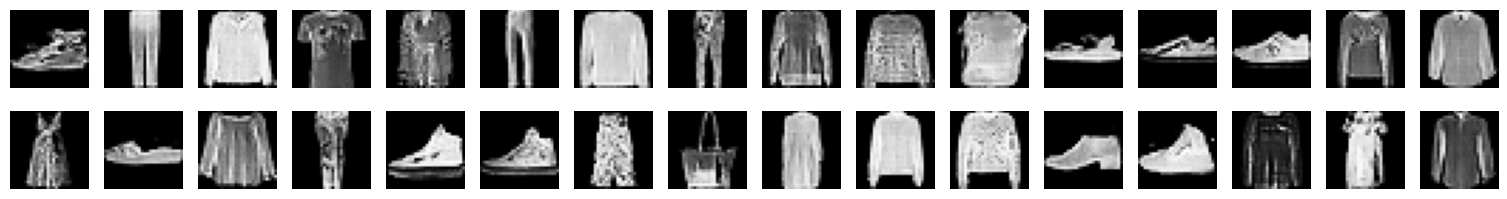

[101/250][150/469]	Loss_D: 0.0982	Loss_G: 4.0464	D(x): 4.8619	D(G(z)): -3.4137 / -4.0129
[101/250][300/469]	Loss_D: 0.3360	Loss_G: 4.0144	D(x): 2.1075	D(G(z)): -4.2863 / -3.9530
[101/250][450/469]	Loss_D: 0.1135	Loss_G: 5.0359	D(x): 3.4136	D(G(z)): -4.4633 / -5.0201
[102/250][150/469]	Loss_D: 0.1894	Loss_G: 3.8660	D(x): 3.1034	D(G(z)): -3.2003 / -3.8285
[102/250][300/469]	Loss_D: 0.2075	Loss_G: 4.3403	D(x): 3.8416	D(G(z)): -2.8020 / -4.3122
[102/250][450/469]	Loss_D: 0.2067	Loss_G: 4.6261	D(x): 2.8383	D(G(z)): -4.6620 / -4.6006
[103/250][150/469]	Loss_D: 0.1774	Loss_G: 4.8535	D(x): 2.9525	D(G(z)): -4.0972 / -4.8333
[103/250][300/469]	Loss_D: 0.1901	Loss_G: 3.8280	D(x): 3.4710	D(G(z)): -3.0066 / -3.7896
[103/250][450/469]	Loss_D: 0.2165	Loss_G: 3.8097	D(x): 2.5090	D(G(z)): -4.2254 / -3.7546
[104/250][150/469]	Loss_D: 0.3013	Loss_G: 4.8072	D(x): 3.7454	D(G(z)): -2.4906 / -4.7892
[104/250][300/469]	Loss_D: 0.1898	Loss_G: 4.3965	D(x): 4.8261	D(G(z)): -2.8044 / -4.3706
[104/250][450/469]	Lo

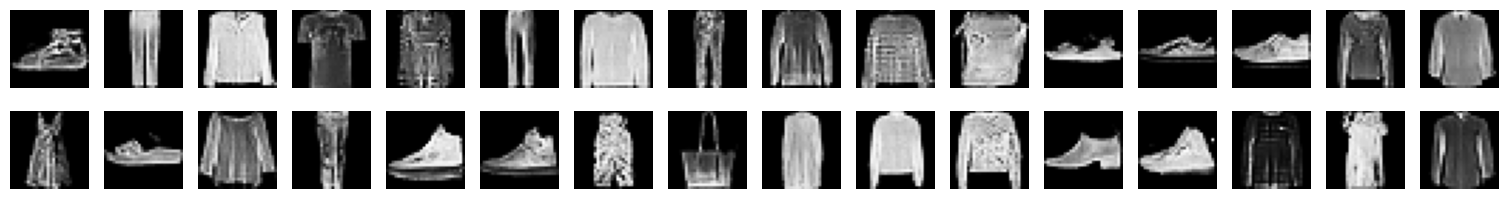

[106/250][150/469]	Loss_D: 0.1810	Loss_G: 4.0792	D(x): 2.7317	D(G(z)): -4.1545 / -4.0366
[106/250][300/469]	Loss_D: 0.3205	Loss_G: 4.7040	D(x): 1.9553	D(G(z)): -5.7142 / -4.6679
[106/250][450/469]	Loss_D: 0.4672	Loss_G: 2.6209	D(x): 1.4769	D(G(z)): -4.2271 / -2.4493
[107/250][150/469]	Loss_D: 0.3446	Loss_G: 4.8085	D(x): 2.5750	D(G(z)): -2.8201 / -4.7867
[107/250][300/469]	Loss_D: 0.2761	Loss_G: 4.3116	D(x): 3.0793	D(G(z)): -2.6317 / -4.2859
[107/250][450/469]	Loss_D: 0.2440	Loss_G: 3.7200	D(x): 2.8654	D(G(z)): -3.9407 / -3.6696
[108/250][150/469]	Loss_D: 0.1988	Loss_G: 4.6027	D(x): 4.0767	D(G(z)): -3.7012 / -4.5737
[108/250][300/469]	Loss_D: 0.1551	Loss_G: 5.0829	D(x): 3.6074	D(G(z)): -3.6879 / -5.0658
[108/250][450/469]	Loss_D: 0.3219	Loss_G: 4.9537	D(x): 4.0430	D(G(z)): -2.1244 / -4.9416
[109/250][150/469]	Loss_D: 0.2875	Loss_G: 4.7397	D(x): 3.5561	D(G(z)): -2.4927 / -4.7219
[109/250][300/469]	Loss_D: 0.3117	Loss_G: 4.4179	D(x): 4.5834	D(G(z)): -2.2160 / -4.3919
[109/250][450/469]	Lo

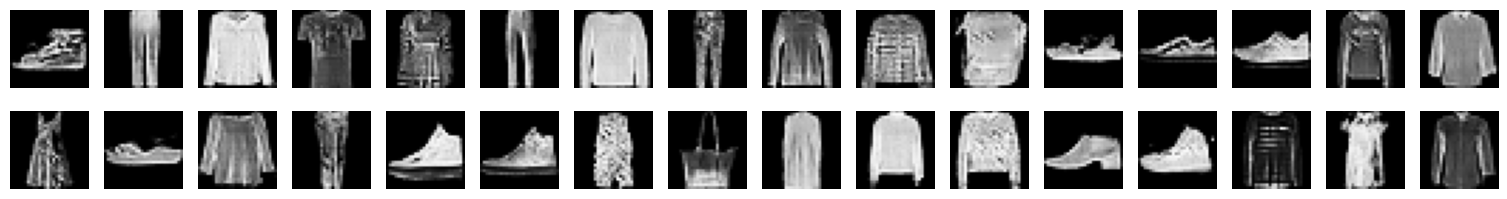

[111/250][150/469]	Loss_D: 0.3649	Loss_G: 6.2833	D(x): 5.3512	D(G(z)): -2.0855 / -6.2783
[111/250][300/469]	Loss_D: 0.1158	Loss_G: 4.8905	D(x): 4.9270	D(G(z)): -3.2729 / -4.8771
[111/250][450/469]	Loss_D: 0.1699	Loss_G: 3.8659	D(x): 3.6267	D(G(z)): -3.3471 / -3.8233
[112/250][150/469]	Loss_D: 0.1706	Loss_G: 5.2760	D(x): 4.2160	D(G(z)): -3.0794 / -5.2652
[112/250][300/469]	Loss_D: 0.2262	Loss_G: 4.3422	D(x): 3.2404	D(G(z)): -3.5490 / -4.3094
[112/250][450/469]	Loss_D: 0.4408	Loss_G: 4.7361	D(x): 3.2774	D(G(z)): -2.1383 / -4.7161
[113/250][150/469]	Loss_D: 0.1915	Loss_G: 4.7259	D(x): 2.9435	D(G(z)): -5.0491 / -4.6940
[113/250][300/469]	Loss_D: 0.1696	Loss_G: 4.2205	D(x): 3.9830	D(G(z)): -3.2130 / -4.1831
[113/250][450/469]	Loss_D: 0.1534	Loss_G: 4.8482	D(x): 4.8983	D(G(z)): -3.0217 / -4.8311
[114/250][150/469]	Loss_D: 0.1860	Loss_G: 4.0954	D(x): 3.1087	D(G(z)): -3.5815 / -4.0617
[114/250][300/469]	Loss_D: 0.1964	Loss_G: 3.5995	D(x): 2.3792	D(G(z)): -4.8287 / -3.5156
[114/250][450/469]	Lo

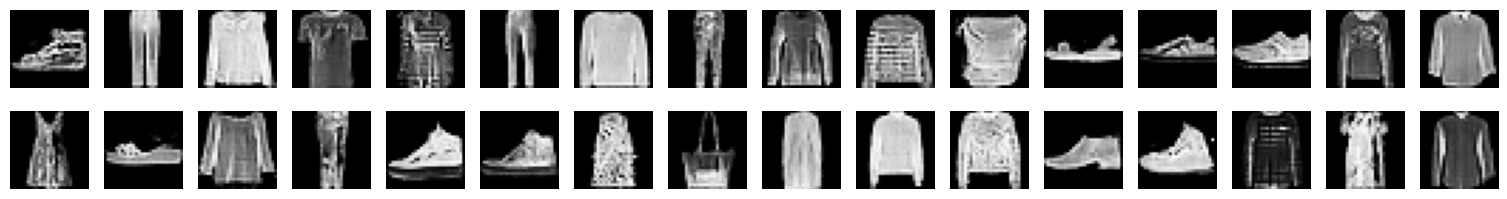

[116/250][150/469]	Loss_D: 0.2505	Loss_G: 4.1743	D(x): 2.3459	D(G(z)): -4.2288 / -4.1305
[116/250][300/469]	Loss_D: 0.1147	Loss_G: 5.0926	D(x): 4.3398	D(G(z)): -3.7299 / -5.0777
[116/250][450/469]	Loss_D: 0.3528	Loss_G: 5.1924	D(x): 4.6482	D(G(z)): -2.0105 / -5.1797
[117/250][150/469]	Loss_D: 0.1517	Loss_G: 4.7550	D(x): 4.0321	D(G(z)): -4.1327 / -4.7324
[117/250][300/469]	Loss_D: 0.2611	Loss_G: 5.6123	D(x): 5.2087	D(G(z)): -2.7867 / -5.6014
[117/250][450/469]	Loss_D: 0.2427	Loss_G: 3.8676	D(x): 3.5541	D(G(z)): -2.6639 / -3.8206
[118/250][150/469]	Loss_D: 0.1653	Loss_G: 4.9263	D(x): 3.7695	D(G(z)): -3.6768 / -4.9093
[118/250][300/469]	Loss_D: 0.1606	Loss_G: 4.5883	D(x): 3.4313	D(G(z)): -3.7966 / -4.5636
[118/250][450/469]	Loss_D: 0.1421	Loss_G: 4.7733	D(x): 3.7578	D(G(z)): -3.8609 / -4.7513
[119/250][150/469]	Loss_D: 0.1434	Loss_G: 5.4898	D(x): 4.1069	D(G(z)): -3.7057 / -5.4772
[119/250][300/469]	Loss_D: 0.2936	Loss_G: 5.2016	D(x): 3.2394	D(G(z)): -2.5325 / -5.1821
[119/250][450/469]	Lo

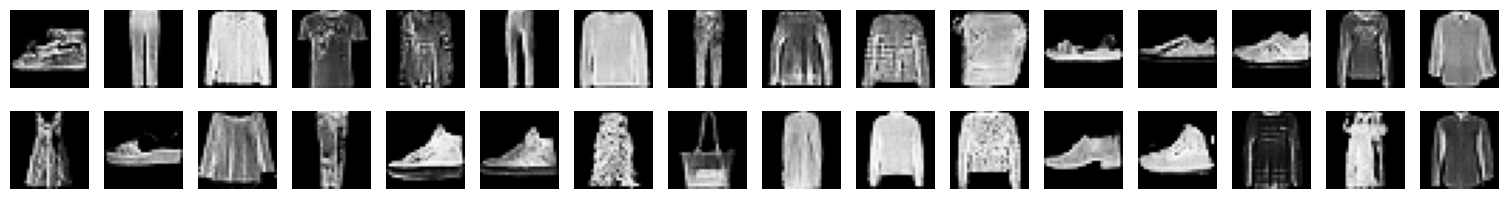

[121/250][150/469]	Loss_D: 0.1408	Loss_G: 4.5001	D(x): 3.9659	D(G(z)): -3.7665 / -4.4692
[121/250][300/469]	Loss_D: 0.0488	Loss_G: 5.1317	D(x): 4.7612	D(G(z)): -4.9167 / -5.1162
[121/250][450/469]	Loss_D: 0.1124	Loss_G: 4.7868	D(x): 3.2924	D(G(z)): -5.0518 / -4.7625
[122/250][150/469]	Loss_D: 0.1449	Loss_G: 6.0435	D(x): 3.2288	D(G(z)): -4.8170 / -6.0363
[122/250][300/469]	Loss_D: 0.1477	Loss_G: 4.4249	D(x): 3.3014	D(G(z)): -4.0301 / -4.3887
[122/250][450/469]	Loss_D: 0.2669	Loss_G: 5.4342	D(x): 3.5360	D(G(z)): -2.9601 / -5.4193
[123/250][150/469]	Loss_D: 0.2566	Loss_G: 3.8773	D(x): 2.5869	D(G(z)): -4.0907 / -3.8278
[123/250][300/469]	Loss_D: 0.2864	Loss_G: 3.2973	D(x): 2.3892	D(G(z)): -4.7060 / -3.1318
[123/250][450/469]	Loss_D: 0.3768	Loss_G: 5.6883	D(x): 4.3627	D(G(z)): -2.2123 / -5.6798
[124/250][150/469]	Loss_D: 0.1326	Loss_G: 5.1568	D(x): 3.4552	D(G(z)): -4.7099 / -5.1360
[124/250][300/469]	Loss_D: 0.1178	Loss_G: 5.1071	D(x): 3.8784	D(G(z)): -3.9542 / -5.0932
[124/250][450/469]	Lo

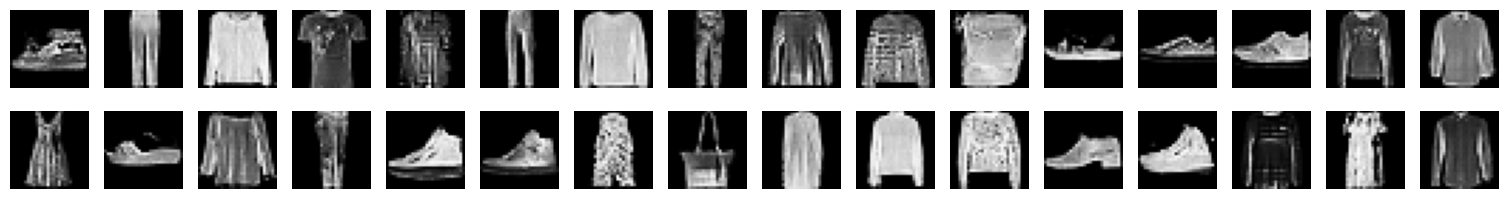

[126/250][150/469]	Loss_D: 0.1590	Loss_G: 4.5328	D(x): 3.4256	D(G(z)): -3.8885 / -4.5059
[126/250][300/469]	Loss_D: 0.2294	Loss_G: 4.2192	D(x): 2.7495	D(G(z)): -5.1347 / -4.1664
[126/250][450/469]	Loss_D: 0.1114	Loss_G: 4.4037	D(x): 3.5824	D(G(z)): -4.3799 / -4.3737
[127/250][150/469]	Loss_D: 0.1292	Loss_G: 4.6820	D(x): 3.8413	D(G(z)): -3.8076 / -4.6612
[127/250][300/469]	Loss_D: 0.0820	Loss_G: 5.2069	D(x): 4.1099	D(G(z)): -4.7247 / -5.1915
[127/250][450/469]	Loss_D: 0.2166	Loss_G: 5.3179	D(x): 3.2572	D(G(z)): -3.9480 / -5.3031
[128/250][150/469]	Loss_D: 0.6386	Loss_G: 2.1523	D(x): 1.1648	D(G(z)): -5.2343 / -1.6248
[128/250][300/469]	Loss_D: 0.1329	Loss_G: 5.1934	D(x): 4.2654	D(G(z)): -3.9059 / -5.1780
[128/250][450/469]	Loss_D: 0.0771	Loss_G: 5.0164	D(x): 5.2510	D(G(z)): -3.7522 / -5.0042
[129/250][150/469]	Loss_D: 0.1040	Loss_G: 5.2655	D(x): 4.0973	D(G(z)): -4.0547 / -5.2528
[129/250][300/469]	Loss_D: 0.2430	Loss_G: 3.6290	D(x): 2.3305	D(G(z)): -4.0441 / -3.5427
[129/250][450/469]	Lo

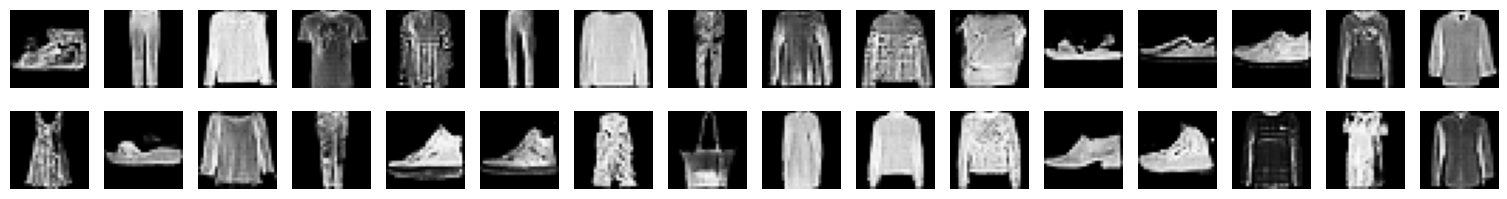

[131/250][150/469]	Loss_D: 0.1139	Loss_G: 4.9871	D(x): 4.7083	D(G(z)): -4.0842 / -4.9666
[131/250][300/469]	Loss_D: 0.0726	Loss_G: 5.9070	D(x): 4.6331	D(G(z)): -4.5340 / -5.8982
[131/250][450/469]	Loss_D: 0.1950	Loss_G: 5.7366	D(x): 3.4279	D(G(z)): -4.6797 / -5.7246
[132/250][150/469]	Loss_D: 0.2393	Loss_G: 3.9316	D(x): 2.5206	D(G(z)): -4.3609 / -3.8603
[132/250][300/469]	Loss_D: 0.1903	Loss_G: 4.0601	D(x): 3.2720	D(G(z)): -3.9885 / -4.0168
[132/250][450/469]	Loss_D: 0.1498	Loss_G: 5.0673	D(x): 2.7989	D(G(z)): -5.6909 / -5.0417
[133/250][150/469]	Loss_D: 0.1364	Loss_G: 5.0574	D(x): 3.6281	D(G(z)): -3.9756 / -5.0367
[133/250][300/469]	Loss_D: 0.1462	Loss_G: 4.6305	D(x): 3.7999	D(G(z)): -4.2880 / -4.6016
[133/250][450/469]	Loss_D: 0.3100	Loss_G: 6.3890	D(x): 4.3250	D(G(z)): -2.5807 / -6.3850
[134/250][150/469]	Loss_D: 0.0669	Loss_G: 5.0134	D(x): 4.1585	D(G(z)): -5.0945 / -4.9958
[134/250][300/469]	Loss_D: 0.1058	Loss_G: 4.5060	D(x): 4.1065	D(G(z)): -4.2118 / -4.4780
[134/250][450/469]	Lo

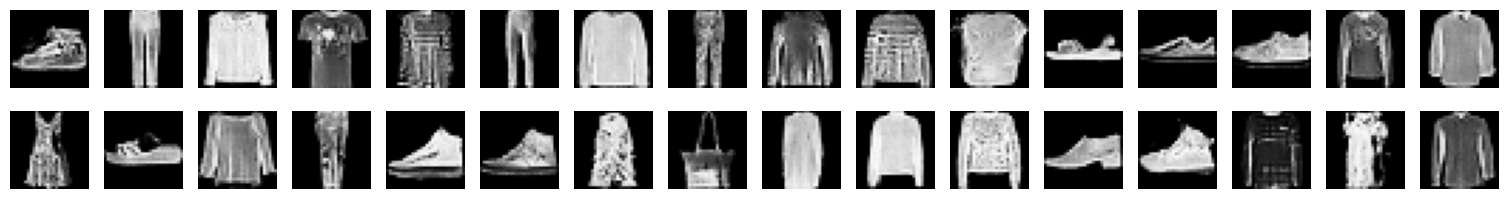

[136/250][150/469]	Loss_D: 0.2487	Loss_G: 3.8393	D(x): 2.4055	D(G(z)): -5.4441 / -3.7468
[136/250][300/469]	Loss_D: 0.1401	Loss_G: 5.3041	D(x): 4.6665	D(G(z)): -3.5149 / -5.2922
[136/250][450/469]	Loss_D: 0.2317	Loss_G: 3.7558	D(x): 2.9590	D(G(z)): -5.3281 / -3.6391
[137/250][150/469]	Loss_D: 0.1477	Loss_G: 5.2823	D(x): 3.7859	D(G(z)): -3.5508 / -5.2706
[137/250][300/469]	Loss_D: 0.1653	Loss_G: 5.2949	D(x): 3.5551	D(G(z)): -4.4172 / -5.2729
[137/250][450/469]	Loss_D: 0.1479	Loss_G: 4.2364	D(x): 3.6049	D(G(z)): -3.6663 / -4.1955
[138/250][150/469]	Loss_D: 0.1709	Loss_G: 5.0406	D(x): 5.6785	D(G(z)): -3.2723 / -5.0236
[138/250][300/469]	Loss_D: 0.1241	Loss_G: 5.0285	D(x): 3.7506	D(G(z)): -4.8352 / -5.0112
[138/250][450/469]	Loss_D: 0.1644	Loss_G: 4.5137	D(x): 3.1623	D(G(z)): -4.9157 / -4.4797
[139/250][150/469]	Loss_D: 0.0839	Loss_G: 5.0802	D(x): 4.1380	D(G(z)): -4.7176 / -5.0615
[139/250][300/469]	Loss_D: 0.0836	Loss_G: 5.0427	D(x): 4.8107	D(G(z)): -3.8027 / -5.0278
[139/250][450/469]	Lo

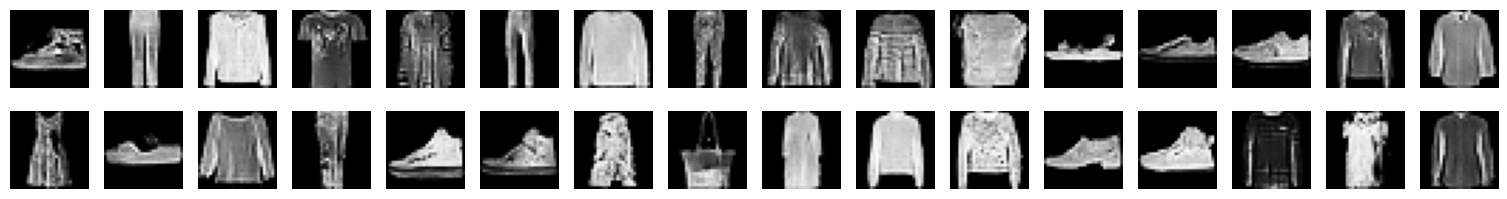

[141/250][150/469]	Loss_D: 0.2357	Loss_G: 4.3089	D(x): 2.8121	D(G(z)): -4.3580 / -4.2355
[141/250][300/469]	Loss_D: 0.3688	Loss_G: 3.2942	D(x): 2.3424	D(G(z)): -4.1168 / -3.0565
[141/250][450/469]	Loss_D: 0.0706	Loss_G: 5.9357	D(x): 5.0101	D(G(z)): -4.9120 / -5.9273
[142/250][150/469]	Loss_D: 0.3012	Loss_G: 3.1766	D(x): 2.0422	D(G(z)): -5.0505 / -3.0410
[142/250][300/469]	Loss_D: 0.1274	Loss_G: 4.8865	D(x): 6.1360	D(G(z)): -3.3270 / -4.8711
[142/250][450/469]	Loss_D: 0.1597	Loss_G: 6.2179	D(x): 5.4552	D(G(z)): -3.4856 / -6.2127
[143/250][150/469]	Loss_D: 0.0686	Loss_G: 5.4690	D(x): 4.1817	D(G(z)): -5.5216 / -5.4571
[143/250][300/469]	Loss_D: 0.0942	Loss_G: 4.9529	D(x): 4.7665	D(G(z)): -4.0402 / -4.9362
[143/250][450/469]	Loss_D: 0.3240	Loss_G: 3.1634	D(x): 2.1910	D(G(z)): -4.8572 / -2.9865
[144/250][150/469]	Loss_D: 0.1986	Loss_G: 4.0499	D(x): 2.8139	D(G(z)): -4.1458 / -3.9975
[144/250][300/469]	Loss_D: 0.1591	Loss_G: 6.1027	D(x): 5.0185	D(G(z)): -4.0104 / -6.0926
[144/250][450/469]	Lo

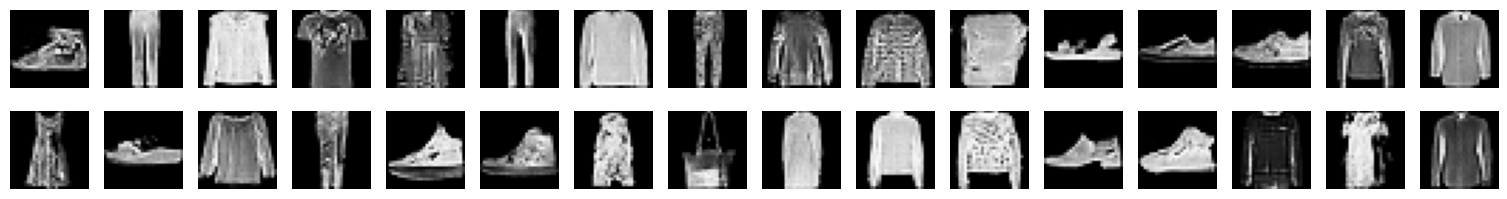

[146/250][150/469]	Loss_D: 0.2188	Loss_G: 6.9700	D(x): 5.4092	D(G(z)): -3.4416 / -6.9663
[146/250][300/469]	Loss_D: 0.1250	Loss_G: 4.8666	D(x): 4.0368	D(G(z)): -4.3149 / -4.8409
[146/250][450/469]	Loss_D: 0.2497	Loss_G: 4.6692	D(x): 3.3961	D(G(z)): -4.4700 / -4.6262
[147/250][150/469]	Loss_D: 0.1371	Loss_G: 4.7644	D(x): 3.3310	D(G(z)): -5.0383 / -4.7333
[147/250][300/469]	Loss_D: 0.1991	Loss_G: 3.9056	D(x): 2.4786	D(G(z)): -4.8627 / -3.8388
[147/250][450/469]	Loss_D: 0.0742	Loss_G: 6.2151	D(x): 4.0132	D(G(z)): -5.9983 / -6.2090
[148/250][150/469]	Loss_D: 0.1291	Loss_G: 5.3086	D(x): 4.1304	D(G(z)): -4.3831 / -5.2935
[148/250][300/469]	Loss_D: 0.0484	Loss_G: 5.4022	D(x): 5.0365	D(G(z)): -5.0547 / -5.3849
[148/250][450/469]	Loss_D: 0.1138	Loss_G: 4.7977	D(x): 4.7415	D(G(z)): -4.0829 / -4.7723
[149/250][150/469]	Loss_D: 0.0501	Loss_G: 6.0272	D(x): 4.4817	D(G(z)): -5.3067 / -6.0203
[149/250][300/469]	Loss_D: 0.0871	Loss_G: 5.2184	D(x): 5.2620	D(G(z)): -4.0613 / -5.2045
[149/250][450/469]	Lo

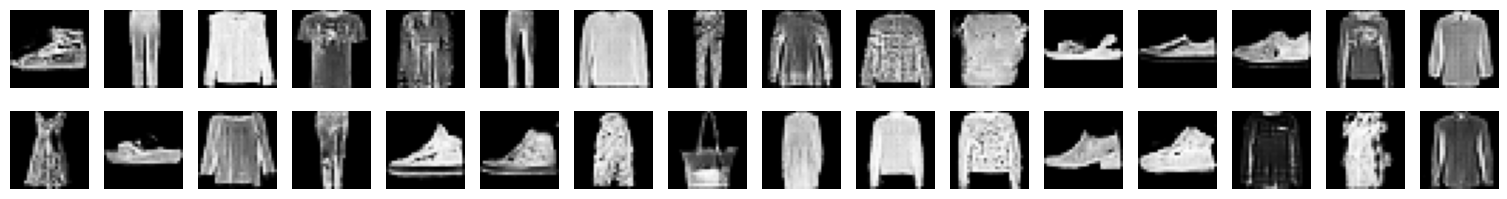

[151/250][150/469]	Loss_D: 0.1703	Loss_G: 3.8461	D(x): 2.8705	D(G(z)): -4.9106 / -3.7813
[151/250][300/469]	Loss_D: 0.1013	Loss_G: 4.5747	D(x): 4.2985	D(G(z)): -3.9127 / -4.5486
[151/250][450/469]	Loss_D: 0.0496	Loss_G: 5.4294	D(x): 4.7531	D(G(z)): -5.1614 / -5.4151
[152/250][150/469]	Loss_D: 0.0767	Loss_G: 5.7408	D(x): 3.9591	D(G(z)): -5.2501 / -5.7286
[152/250][300/469]	Loss_D: 0.0880	Loss_G: 4.6869	D(x): 5.1010	D(G(z)): -4.4454 / -4.6591
[152/250][450/469]	Loss_D: 0.0777	Loss_G: 4.7615	D(x): 4.0157	D(G(z)): -5.0573 / -4.7366
[153/250][150/469]	Loss_D: 0.0872	Loss_G: 4.9508	D(x): 3.9189	D(G(z)): -5.1779 / -4.9260
[153/250][300/469]	Loss_D: 0.0691	Loss_G: 4.8233	D(x): 4.6632	D(G(z)): -4.8360 / -4.7996
[153/250][450/469]	Loss_D: 0.1155	Loss_G: 5.2495	D(x): 4.1865	D(G(z)): -4.7397 / -5.2294
[154/250][150/469]	Loss_D: 0.1341	Loss_G: 5.1041	D(x): 3.7958	D(G(z)): -4.4226 / -5.0812
[154/250][300/469]	Loss_D: 0.1987	Loss_G: 6.0757	D(x): 4.4585	D(G(z)): -4.9725 / -6.0536
[154/250][450/469]	Lo

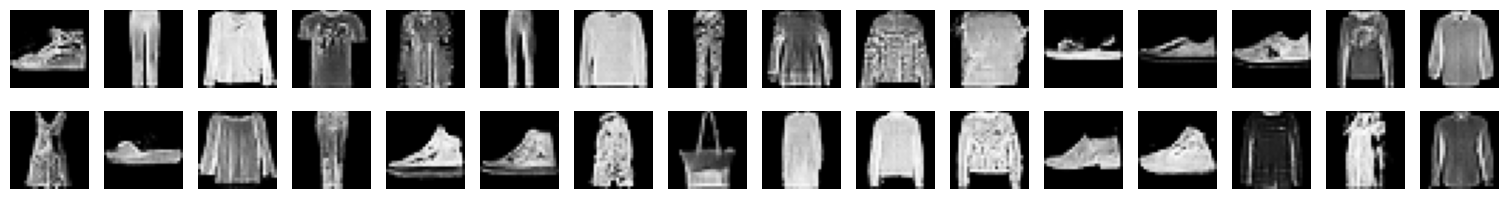

[156/250][150/469]	Loss_D: 0.1058	Loss_G: 5.6316	D(x): 6.0584	D(G(z)): -3.8836 / -5.6193
[156/250][300/469]	Loss_D: 0.2442	Loss_G: 6.4033	D(x): 5.5137	D(G(z)): -2.8764 / -6.3984
[156/250][450/469]	Loss_D: 0.2246	Loss_G: 5.9886	D(x): 5.6729	D(G(z)): -2.8526 / -5.9800
[157/250][150/469]	Loss_D: 0.0586	Loss_G: 5.2343	D(x): 5.0181	D(G(z)): -4.8110 / -5.2170
[157/250][300/469]	Loss_D: 0.1022	Loss_G: 5.5502	D(x): 3.8175	D(G(z)): -5.8106 / -5.5380
[157/250][450/469]	Loss_D: 0.1703	Loss_G: 5.5960	D(x): 4.3744	D(G(z)): -4.0258 / -5.5834
[158/250][150/469]	Loss_D: 0.1412	Loss_G: 5.0432	D(x): 3.5681	D(G(z)): -4.2665 / -5.0251
[158/250][300/469]	Loss_D: 0.1743	Loss_G: 4.6083	D(x): 4.1574	D(G(z)): -3.4329 / -4.5833
[158/250][450/469]	Loss_D: 0.0780	Loss_G: 5.0397	D(x): 5.9256	D(G(z)): -3.8102 / -5.0238
[159/250][150/469]	Loss_D: 0.0527	Loss_G: 5.4763	D(x): 5.1753	D(G(z)): -5.3750 / -5.4646
[159/250][300/469]	Loss_D: 0.0706	Loss_G: 5.4047	D(x): 3.9340	D(G(z)): -5.1053 / -5.3906
[159/250][450/469]	Lo

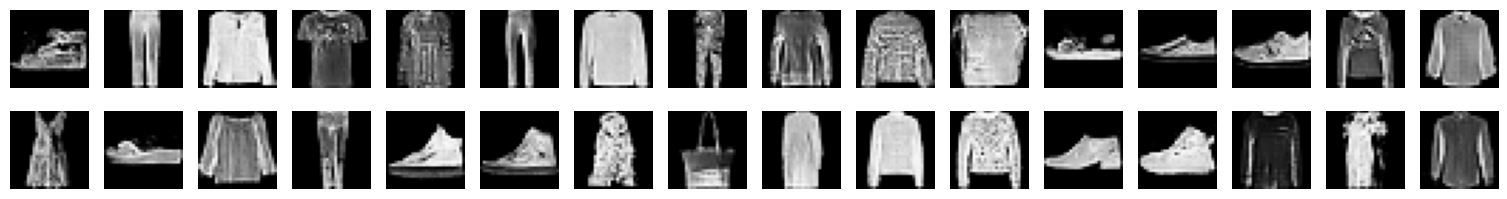

[161/250][150/469]	Loss_D: 0.0973	Loss_G: 5.2207	D(x): 5.0191	D(G(z)): -4.3032 / -5.2051
[161/250][300/469]	Loss_D: 0.0768	Loss_G: 5.9810	D(x): 6.1723	D(G(z)): -4.2464 / -5.9743
[161/250][450/469]	Loss_D: 0.0758	Loss_G: 5.5581	D(x): 3.9036	D(G(z)): -5.9240 / -5.5433
[162/250][150/469]	Loss_D: 0.1693	Loss_G: 5.6440	D(x): 4.3797	D(G(z)): -3.7212 / -5.6324
[162/250][300/469]	Loss_D: 0.0749	Loss_G: 5.3308	D(x): 4.8662	D(G(z)): -4.7209 / -5.3157
[162/250][450/469]	Loss_D: 0.1011	Loss_G: 4.8617	D(x): 3.8667	D(G(z)): -4.6987 / -4.8389
[163/250][150/469]	Loss_D: 0.0536	Loss_G: 5.3722	D(x): 4.6382	D(G(z)): -4.8731 / -5.3594
[163/250][300/469]	Loss_D: 0.0581	Loss_G: 5.3813	D(x): 5.1860	D(G(z)): -4.6528 / -5.3675
[163/250][450/469]	Loss_D: 0.1447	Loss_G: 4.5850	D(x): 3.6939	D(G(z)): -4.3646 / -4.5590
[164/250][150/469]	Loss_D: 0.0567	Loss_G: 5.6045	D(x): 4.1108	D(G(z)): -5.3658 / -5.5906
[164/250][300/469]	Loss_D: 0.1384	Loss_G: 5.5938	D(x): 4.2350	D(G(z)): -4.2897 / -5.5815
[164/250][450/469]	Lo

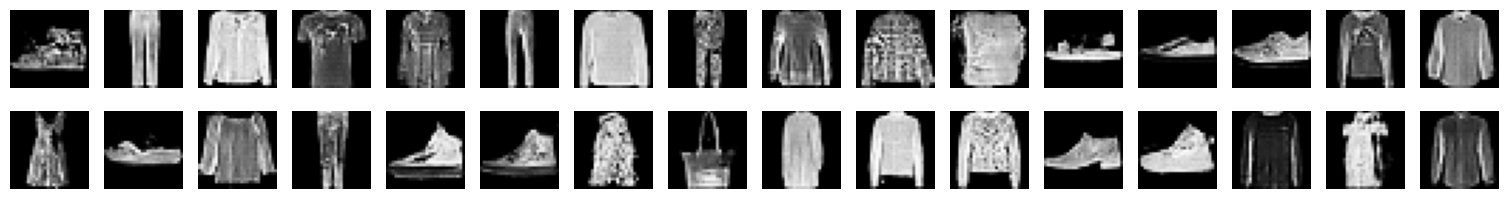

[166/250][150/469]	Loss_D: 0.0726	Loss_G: 5.8259	D(x): 3.9428	D(G(z)): -6.2206 / -5.8125
[166/250][300/469]	Loss_D: 0.1398	Loss_G: 5.5733	D(x): 3.2167	D(G(z)): -6.7871 / -5.5577
[166/250][450/469]	Loss_D: 0.0669	Loss_G: 4.9502	D(x): 5.0900	D(G(z)): -4.4816 / -4.9257
[167/250][150/469]	Loss_D: 0.0267	Loss_G: 6.2859	D(x): 5.2421	D(G(z)): -5.4991 / -6.2800
[167/250][300/469]	Loss_D: 0.0387	Loss_G: 5.9965	D(x): 5.0744	D(G(z)): -5.5120 / -5.9857
[167/250][450/469]	Loss_D: 0.1252	Loss_G: 6.5912	D(x): 5.4639	D(G(z)): -3.6163 / -6.5875
[168/250][150/469]	Loss_D: 0.0634	Loss_G: 6.3374	D(x): 6.3963	D(G(z)): -4.7537 / -6.3323
[168/250][300/469]	Loss_D: 0.0718	Loss_G: 5.4509	D(x): 4.0921	D(G(z)): -6.2577 / -5.4346
[168/250][450/469]	Loss_D: 0.0676	Loss_G: 5.7083	D(x): 4.7594	D(G(z)): -6.3399 / -5.6935
[169/250][150/469]	Loss_D: 0.1303	Loss_G: 5.6020	D(x): 3.7941	D(G(z)): -4.2025 / -5.5915
[169/250][300/469]	Loss_D: 0.1022	Loss_G: 4.8600	D(x): 3.9147	D(G(z)): -4.2998 / -4.8415
[169/250][450/469]	Lo

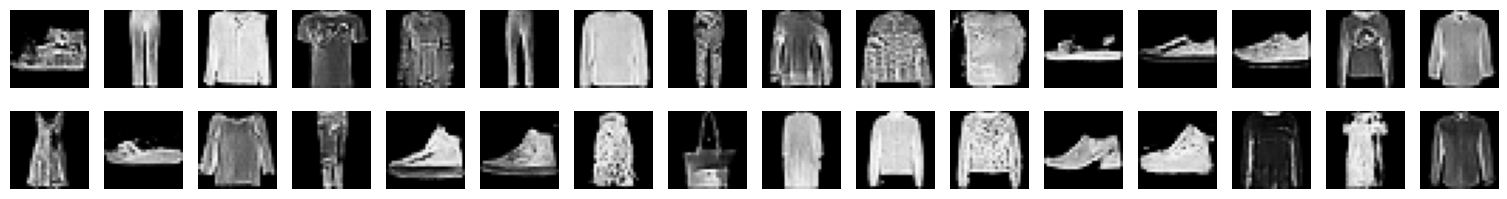

[171/250][150/469]	Loss_D: 0.1297	Loss_G: 5.0652	D(x): 4.1358	D(G(z)): -3.8157 / -5.0471
[171/250][300/469]	Loss_D: 0.1145	Loss_G: 4.3504	D(x): 3.4273	D(G(z)): -4.7472 / -4.3102
[171/250][450/469]	Loss_D: 0.0500	Loss_G: 5.9101	D(x): 4.3086	D(G(z)): -6.0893 / -5.8993
[172/250][150/469]	Loss_D: 0.0753	Loss_G: 5.1286	D(x): 4.1302	D(G(z)): -4.9153 / -5.1102
[172/250][300/469]	Loss_D: 0.0281	Loss_G: 5.5133	D(x): 5.5155	D(G(z)): -5.4117 / -5.4994
[172/250][450/469]	Loss_D: 0.0860	Loss_G: 5.1681	D(x): 4.1668	D(G(z)): -4.7715 / -5.1503
[173/250][150/469]	Loss_D: 0.0334	Loss_G: 5.6039	D(x): 5.3147	D(G(z)): -5.7477 / -5.5921
[173/250][300/469]	Loss_D: 0.0845	Loss_G: 6.1361	D(x): 5.2289	D(G(z)): -4.2987 / -6.1284
[173/250][450/469]	Loss_D: 0.2343	Loss_G: 5.7373	D(x): 4.2012	D(G(z)): -4.0706 / -5.7204
[174/250][150/469]	Loss_D: 0.1879	Loss_G: 4.4850	D(x): 2.9147	D(G(z)): -5.0390 / -4.4273
[174/250][300/469]	Loss_D: 0.0705	Loss_G: 4.8741	D(x): 4.9895	D(G(z)): -4.3679 / -4.8561
[174/250][450/469]	Lo

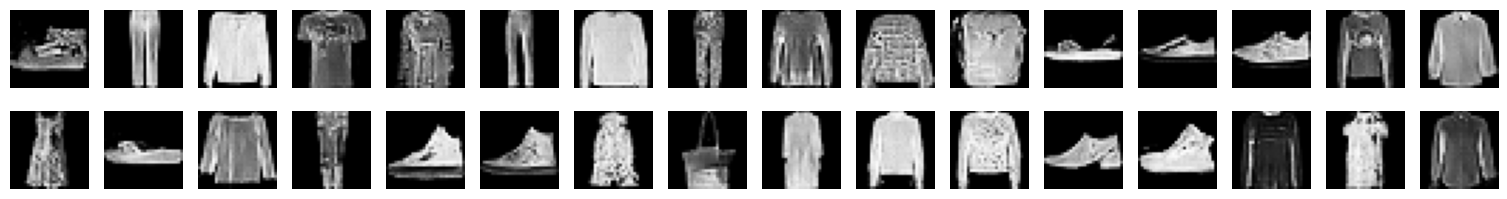

[176/250][150/469]	Loss_D: 0.2087	Loss_G: 4.6841	D(x): 3.6909	D(G(z)): -3.6202 / -4.6587
[176/250][300/469]	Loss_D: 0.0574	Loss_G: 5.3465	D(x): 5.8736	D(G(z)): -4.6580 / -5.3304
[176/250][450/469]	Loss_D: 0.1031	Loss_G: 5.1388	D(x): 3.9002	D(G(z)): -5.3266 / -5.1171
[177/250][150/469]	Loss_D: 0.1639	Loss_G: 7.1066	D(x): 7.5667	D(G(z)): -3.3905 / -7.1044
[177/250][300/469]	Loss_D: 0.1238	Loss_G: 5.8228	D(x): 4.3537	D(G(z)): -4.0913 / -5.8090
[177/250][450/469]	Loss_D: 0.0633	Loss_G: 6.1251	D(x): 4.4996	D(G(z)): -5.6097 / -6.1164
[178/250][150/469]	Loss_D: 0.0364	Loss_G: 6.0021	D(x): 5.6513	D(G(z)): -5.5242 / -5.9928
[178/250][300/469]	Loss_D: 0.4644	Loss_G: 3.0240	D(x): 2.8299	D(G(z)): -3.7090 / -2.8320
[178/250][450/469]	Loss_D: 0.2113	Loss_G: 3.7817	D(x): 2.8984	D(G(z)): -4.7707 / -3.7101
[179/250][150/469]	Loss_D: 0.0515	Loss_G: 5.5854	D(x): 4.2092	D(G(z)): -5.7490 / -5.5736
[179/250][300/469]	Loss_D: 0.1444	Loss_G: 4.0294	D(x): 2.8930	D(G(z)): -4.9182 / -3.9669
[179/250][450/469]	Lo

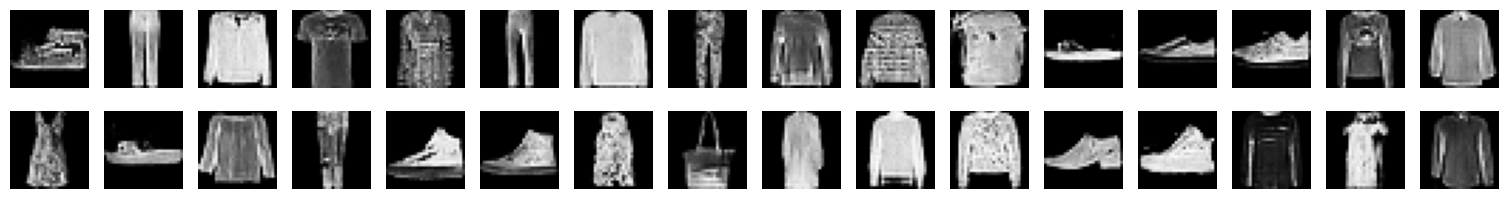

[181/250][150/469]	Loss_D: 0.0713	Loss_G: 6.4456	D(x): 7.4471	D(G(z)): -4.5212 / -6.4378
[181/250][300/469]	Loss_D: 0.0823	Loss_G: 6.3316	D(x): 4.2456	D(G(z)): -5.6577 / -6.3230
[181/250][450/469]	Loss_D: 0.1630	Loss_G: 5.0473	D(x): 3.5514	D(G(z)): -5.2454 / -5.0223
[182/250][150/469]	Loss_D: 0.0307	Loss_G: 6.5586	D(x): 5.6301	D(G(z)): -6.2251 / -6.5513
[182/250][300/469]	Loss_D: 0.0604	Loss_G: 6.3832	D(x): 5.6243	D(G(z)): -4.9222 / -6.3761
[182/250][450/469]	Loss_D: 0.1456	Loss_G: 6.3014	D(x): 4.4400	D(G(z)): -4.8254 / -6.2882
[183/250][150/469]	Loss_D: 0.0921	Loss_G: 5.4514	D(x): 3.9094	D(G(z)): -6.2089 / -5.4325
[183/250][300/469]	Loss_D: 0.0837	Loss_G: 5.9463	D(x): 5.1971	D(G(z)): -4.8765 / -5.9356
[183/250][450/469]	Loss_D: 0.1674	Loss_G: 4.2590	D(x): 2.9070	D(G(z)): -6.0277 / -4.2004
[184/250][150/469]	Loss_D: 0.0980	Loss_G: 5.1965	D(x): 5.2972	D(G(z)): -4.1244 / -5.1797
[184/250][300/469]	Loss_D: 0.1346	Loss_G: 5.1873	D(x): 3.8231	D(G(z)): -4.8803 / -5.1719
[184/250][450/469]	Lo

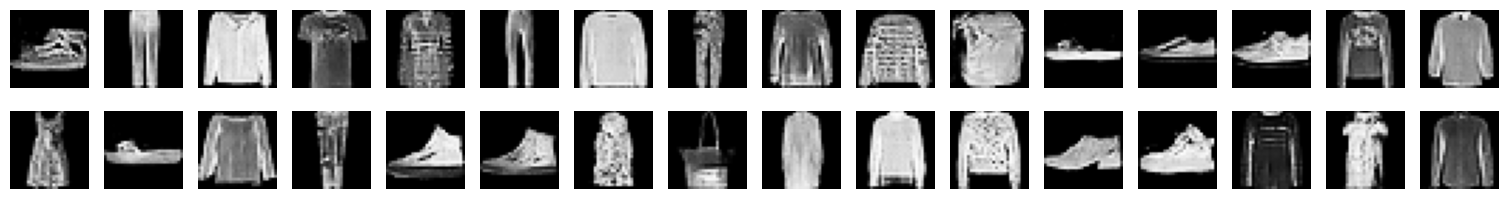

[186/250][150/469]	Loss_D: 0.0589	Loss_G: 5.6142	D(x): 4.2292	D(G(z)): -5.4653 / -5.6015
[186/250][300/469]	Loss_D: 0.1629	Loss_G: 7.1736	D(x): 6.5632	D(G(z)): -3.4682 / -7.1711
[186/250][450/469]	Loss_D: 0.0807	Loss_G: 6.5971	D(x): 5.3471	D(G(z)): -4.9534 / -6.5913
[187/250][150/469]	Loss_D: 0.0558	Loss_G: 5.6937	D(x): 4.9596	D(G(z)): -5.3600 / -5.6793
[187/250][300/469]	Loss_D: 0.0267	Loss_G: 6.3311	D(x): 5.1334	D(G(z)): -5.8953 / -6.3255
[187/250][450/469]	Loss_D: 0.0406	Loss_G: 6.0008	D(x): 5.2554	D(G(z)): -5.9002 / -5.9919
[188/250][150/469]	Loss_D: 0.0304	Loss_G: 6.5327	D(x): 6.6359	D(G(z)): -6.0723 / -6.5263
[188/250][300/469]	Loss_D: 0.1949	Loss_G: 7.3233	D(x): 5.4541	D(G(z)): -3.8581 / -7.3198
[188/250][450/469]	Loss_D: 0.0979	Loss_G: 5.8222	D(x): 4.7722	D(G(z)): -5.5234 / -5.8037
[189/250][150/469]	Loss_D: 0.3828	Loss_G: 9.3834	D(x): 7.3627	D(G(z)): -2.8327 / -9.3827
[189/250][300/469]	Loss_D: 0.1082	Loss_G: 5.7796	D(x): 4.6559	D(G(z)): -4.6708 / -5.7686
[189/250][450/469]	Lo

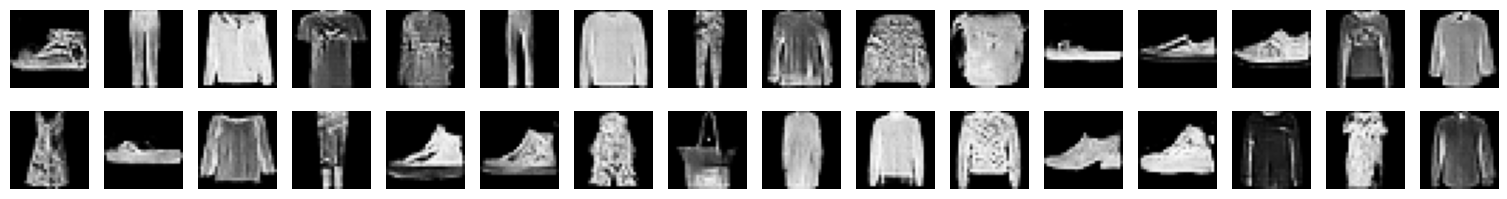

[191/250][150/469]	Loss_D: 0.0675	Loss_G: 5.6500	D(x): 3.9917	D(G(z)): -5.5701 / -5.6388
[191/250][300/469]	Loss_D: 0.1255	Loss_G: 5.2779	D(x): 4.8307	D(G(z)): -4.0533 / -5.2579
[191/250][450/469]	Loss_D: 0.1275	Loss_G: 4.8758	D(x): 3.4032	D(G(z)): -5.2871 / -4.8499
[192/250][150/469]	Loss_D: 1.9662	Loss_G: 1.2087	D(x): -0.7635	D(G(z)): -9.5034 / 1.5313
[192/250][300/469]	Loss_D: 0.0582	Loss_G: 5.3821	D(x): 4.6426	D(G(z)): -5.9436 / -5.3633
[192/250][450/469]	Loss_D: 0.0739	Loss_G: 6.2484	D(x): 4.9145	D(G(z)): -5.6854 / -6.2378
[193/250][150/469]	Loss_D: 0.0330	Loss_G: 6.5778	D(x): 5.8035	D(G(z)): -6.2398 / -6.5714
[193/250][300/469]	Loss_D: 0.0375	Loss_G: 6.5448	D(x): 6.7427	D(G(z)): -5.8121 / -6.5376
[193/250][450/469]	Loss_D: 0.1012	Loss_G: 5.3112	D(x): 4.0315	D(G(z)): -5.0680 / -5.2943
[194/250][150/469]	Loss_D: 0.0568	Loss_G: 6.7426	D(x): 5.2125	D(G(z)): -6.1559 / -6.7365
[194/250][300/469]	Loss_D: 0.2456	Loss_G: 5.3401	D(x): 4.2208	D(G(z)): -4.4630 / -5.3178
[194/250][450/469]	Lo

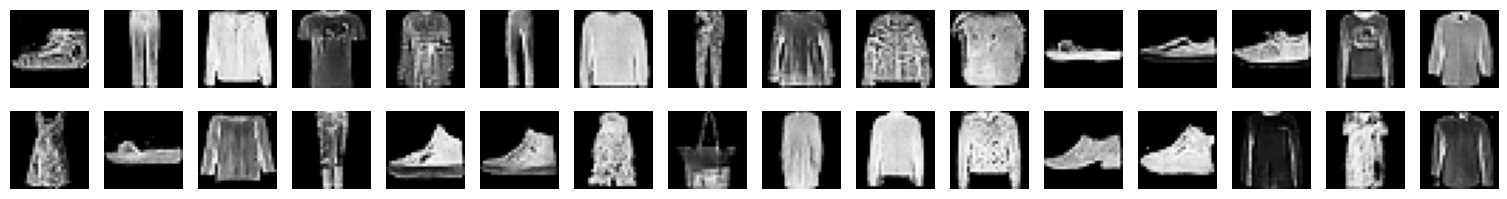

[196/250][150/469]	Loss_D: 0.1651	Loss_G: 4.9812	D(x): 3.7602	D(G(z)): -5.2697 / -4.9530
[196/250][300/469]	Loss_D: 0.0736	Loss_G: 5.8605	D(x): 4.3584	D(G(z)): -5.6536 / -5.8508
[196/250][450/469]	Loss_D: 0.1192	Loss_G: 6.3256	D(x): 6.4359	D(G(z)): -4.4038 / -6.3177
[197/250][150/469]	Loss_D: 0.0876	Loss_G: 8.2094	D(x): 3.9683	D(G(z)): -8.3769 / -8.2075
[197/250][300/469]	Loss_D: 0.2215	Loss_G: 5.1690	D(x): 3.5628	D(G(z)): -4.9060 / -5.1458
[197/250][450/469]	Loss_D: 0.1349	Loss_G: 4.9870	D(x): 3.3636	D(G(z)): -5.6727 / -4.9585
[198/250][150/469]	Loss_D: 0.0667	Loss_G: 5.3477	D(x): 5.2526	D(G(z)): -4.9239 / -5.3312
[198/250][300/469]	Loss_D: 0.0495	Loss_G: 5.6843	D(x): 5.7185	D(G(z)): -5.6553 / -5.6676
[198/250][450/469]	Loss_D: 0.0410	Loss_G: 6.1851	D(x): 4.8495	D(G(z)): -6.7045 / -6.1766
[199/250][150/469]	Loss_D: 0.0344	Loss_G: 5.5574	D(x): 5.3553	D(G(z)): -5.1415 / -5.5453
[199/250][300/469]	Loss_D: 0.0414	Loss_G: 6.7224	D(x): 5.4602	D(G(z)): -5.9684 / -6.7155
[199/250][450/469]	Lo

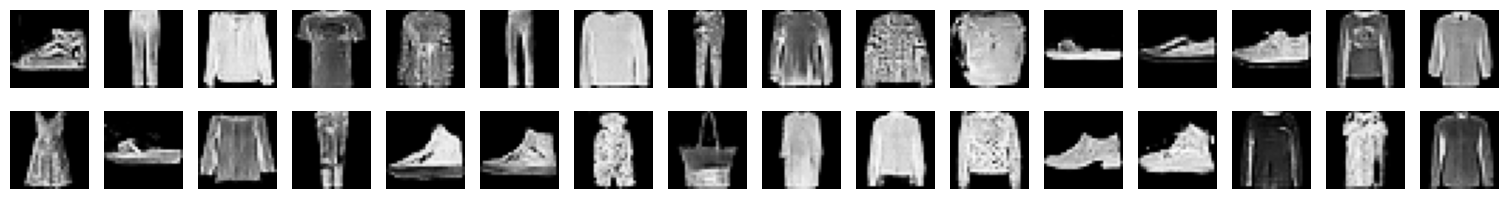

[201/250][150/469]	Loss_D: 0.0819	Loss_G: 6.1615	D(x): 7.1348	D(G(z)): -5.2352 / -6.1453
[201/250][300/469]	Loss_D: 0.0744	Loss_G: 5.2709	D(x): 4.1758	D(G(z)): -5.3485 / -5.2534
[201/250][450/469]	Loss_D: 0.1142	Loss_G: 5.2000	D(x): 3.6029	D(G(z)): -6.0058 / -5.1700
[202/250][150/469]	Loss_D: 0.0858	Loss_G: 5.9566	D(x): 7.3130	D(G(z)): -4.0252 / -5.9491
[202/250][300/469]	Loss_D: 0.1108	Loss_G: 5.5418	D(x): 3.4116	D(G(z)): -6.6692 / -5.5193
[202/250][450/469]	Loss_D: 0.0634	Loss_G: 5.7555	D(x): 5.5001	D(G(z)): -4.8650 / -5.7455
[203/250][150/469]	Loss_D: 0.0700	Loss_G: 6.2409	D(x): 5.6174	D(G(z)): -5.4402 / -6.2311
[203/250][300/469]	Loss_D: 0.0178	Loss_G: 6.9307	D(x): 6.1106	D(G(z)): -6.6498 / -6.9256
[203/250][450/469]	Loss_D: 0.0901	Loss_G: 6.7282	D(x): 6.5748	D(G(z)): -4.2195 / -6.7249
[204/250][150/469]	Loss_D: 0.0311	Loss_G: 5.8823	D(x): 7.3188	D(G(z)): -5.3089 / -5.8733
[204/250][300/469]	Loss_D: 0.0903	Loss_G: 4.8598	D(x): 4.3570	D(G(z)): -5.8054 / -4.8258
[204/250][450/469]	Lo

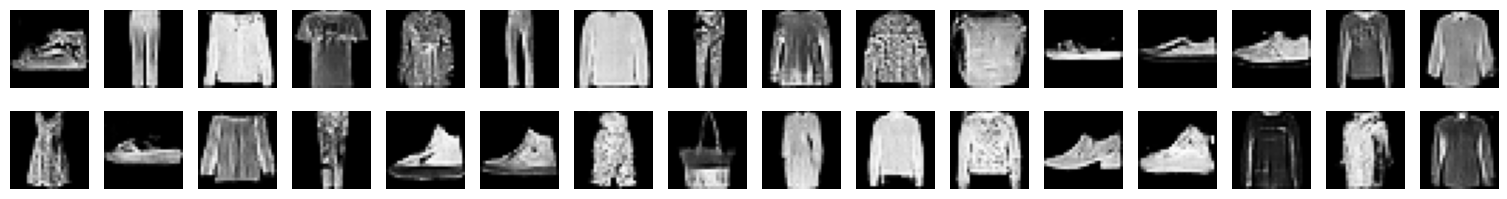

[206/250][150/469]	Loss_D: 0.0265	Loss_G: 7.1792	D(x): 7.0738	D(G(z)): -5.7335 / -7.1762
[206/250][300/469]	Loss_D: 0.0400	Loss_G: 6.4053	D(x): 5.0933	D(G(z)): -6.0518 / -6.3980
[206/250][450/469]	Loss_D: 0.1025	Loss_G: 6.2602	D(x): 5.4723	D(G(z)): -5.0468 / -6.2502
[207/250][150/469]	Loss_D: 0.1833	Loss_G: 6.8713	D(x): 5.3427	D(G(z)): -3.9853 / -6.8671
[207/250][300/469]	Loss_D: 0.1017	Loss_G: 7.4843	D(x): 5.4256	D(G(z)): -4.8166 / -7.4815
[207/250][450/469]	Loss_D: 0.1062	Loss_G: 5.8451	D(x): 3.6092	D(G(z)): -7.2061 / -5.8247
[208/250][150/469]	Loss_D: 0.0812	Loss_G: 5.8900	D(x): 5.3819	D(G(z)): -4.7004 / -5.8797
[208/250][300/469]	Loss_D: 0.0415	Loss_G: 6.2270	D(x): 6.0669	D(G(z)): -5.2076 / -6.2182
[208/250][450/469]	Loss_D: 0.0361	Loss_G: 7.4298	D(x): 5.7957	D(G(z)): -6.8573 / -7.4259
[209/250][150/469]	Loss_D: 0.0309	Loss_G: 6.1164	D(x): 5.8497	D(G(z)): -5.5014 / -6.1079
[209/250][300/469]	Loss_D: 0.0641	Loss_G: 5.7922	D(x): 4.5949	D(G(z)): -5.0519 / -5.7794
[209/250][450/469]	Lo

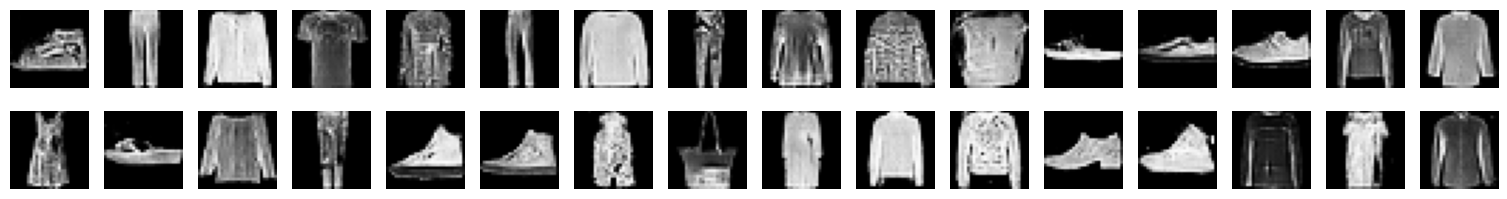

[211/250][150/469]	Loss_D: 0.0270	Loss_G: 6.6117	D(x): 5.5120	D(G(z)): -6.4635 / -6.6044
[211/250][300/469]	Loss_D: 0.0751	Loss_G: 6.2511	D(x): 5.9781	D(G(z)): -5.3570 / -6.2373
[211/250][450/469]	Loss_D: 0.1378	Loss_G: 5.5760	D(x): 5.9748	D(G(z)): -4.4095 / -5.5609
[212/250][150/469]	Loss_D: 0.0320	Loss_G: 5.7827	D(x): 6.2608	D(G(z)): -5.5740 / -5.7673
[212/250][300/469]	Loss_D: 0.0210	Loss_G: 6.4039	D(x): 6.2421	D(G(z)): -6.0683 / -6.3970
[212/250][450/469]	Loss_D: 0.0544	Loss_G: 5.8415	D(x): 5.6539	D(G(z)): -4.9871 / -5.8293
[213/250][150/469]	Loss_D: 0.0896	Loss_G: 5.7328	D(x): 4.4714	D(G(z)): -5.2117 / -5.7170
[213/250][300/469]	Loss_D: 0.0291	Loss_G: 6.4806	D(x): 7.1184	D(G(z)): -5.5832 / -6.4726
[213/250][450/469]	Loss_D: 0.0297	Loss_G: 6.5180	D(x): 5.3594	D(G(z)): -6.5101 / -6.5108
[214/250][150/469]	Loss_D: 0.0294	Loss_G: 6.5276	D(x): 6.7064	D(G(z)): -5.8418 / -6.5201
[214/250][300/469]	Loss_D: 0.0273	Loss_G: 7.4696	D(x): 5.2293	D(G(z)): -7.4732 / -7.4654
[214/250][450/469]	Lo

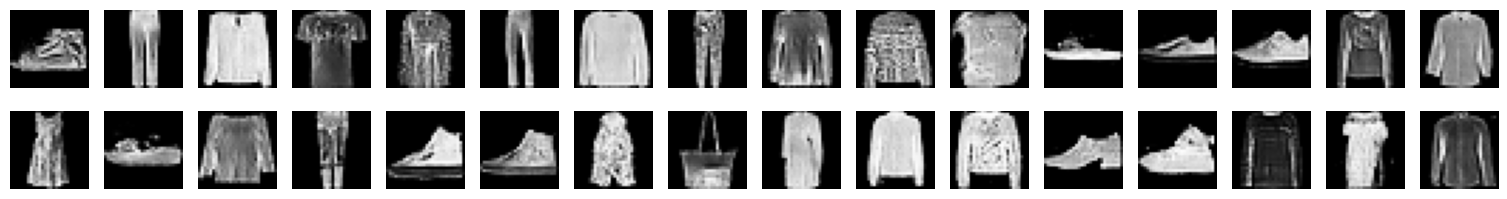

[216/250][150/469]	Loss_D: 0.0832	Loss_G: 6.7247	D(x): 5.7542	D(G(z)): -5.7651 / -6.7176
[216/250][300/469]	Loss_D: 0.0862	Loss_G: 6.9716	D(x): 5.6807	D(G(z)): -5.7640 / -6.9644
[216/250][450/469]	Loss_D: 0.0339	Loss_G: 6.3882	D(x): 6.5312	D(G(z)): -5.9289 / -6.3811
[217/250][150/469]	Loss_D: 0.0375	Loss_G: 6.9807	D(x): 5.4607	D(G(z)): -5.8368 / -6.9753
[217/250][300/469]	Loss_D: 0.0497	Loss_G: 6.8900	D(x): 4.7344	D(G(z)): -6.6530 / -6.8830
[217/250][450/469]	Loss_D: 0.0191	Loss_G: 6.2973	D(x): 7.0157	D(G(z)): -6.0204 / -6.2883
[218/250][150/469]	Loss_D: 0.0334	Loss_G: 6.1049	D(x): 5.3315	D(G(z)): -6.0168 / -6.0952
[218/250][300/469]	Loss_D: 0.0239	Loss_G: 7.5230	D(x): 5.5776	D(G(z)): -7.7079 / -7.5193
[218/250][450/469]	Loss_D: 0.1441	Loss_G: 4.9041	D(x): 3.7513	D(G(z)): -4.8611 / -4.8757
[219/250][150/469]	Loss_D: 0.0762	Loss_G: 6.2856	D(x): 6.5111	D(G(z)): -4.5915 / -6.2787
[219/250][300/469]	Loss_D: 0.0285	Loss_G: 6.5247	D(x): 5.9649	D(G(z)): -6.4525 / -6.5173
[219/250][450/469]	Lo

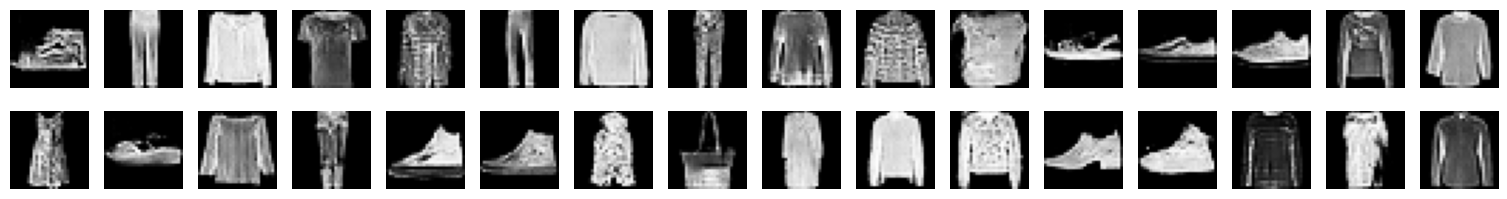

[221/250][150/469]	Loss_D: 0.0493	Loss_G: 6.2605	D(x): 4.3782	D(G(z)): -6.6341 / -6.2510
[221/250][300/469]	Loss_D: 0.0758	Loss_G: 6.1337	D(x): 6.4798	D(G(z)): -5.0536 / -6.1191
[221/250][450/469]	Loss_D: 2.1186	Loss_G: 4.0291	D(x): 1.4529	D(G(z)): -5.8956 / -2.8734
[222/250][150/469]	Loss_D: 0.0852	Loss_G: 4.7955	D(x): 4.3630	D(G(z)): -4.7076 / -4.7670
[222/250][300/469]	Loss_D: 0.0994	Loss_G: 5.7779	D(x): 5.9656	D(G(z)): -4.5370 / -5.7603
[222/250][450/469]	Loss_D: 0.0744	Loss_G: 5.4011	D(x): 4.6899	D(G(z)): -4.6587 / -5.3869
[223/250][150/469]	Loss_D: 0.0300	Loss_G: 6.3497	D(x): 5.7906	D(G(z)): -5.6293 / -6.3419
[223/250][300/469]	Loss_D: 0.0331	Loss_G: 6.4726	D(x): 7.0037	D(G(z)): -6.2502 / -6.4658
[223/250][450/469]	Loss_D: 0.0611	Loss_G: 6.5246	D(x): 6.9101	D(G(z)): -5.0438 / -6.5185
[224/250][150/469]	Loss_D: 0.0199	Loss_G: 8.1046	D(x): 6.0080	D(G(z)): -7.3192 / -8.1019
[224/250][300/469]	Loss_D: 0.0347	Loss_G: 6.6407	D(x): 6.1703	D(G(z)): -6.2069 / -6.6322
[224/250][450/469]	Lo

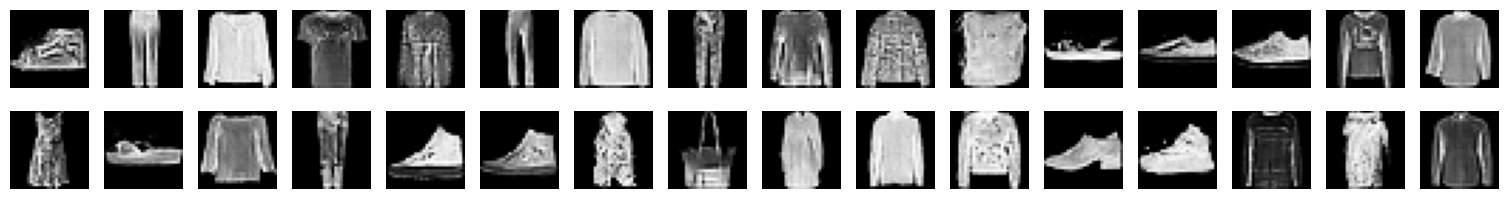

[226/250][150/469]	Loss_D: 0.0192	Loss_G: 6.3544	D(x): 6.1508	D(G(z)): -6.5313 / -6.3445
[226/250][300/469]	Loss_D: 0.2526	Loss_G: 4.5835	D(x): 2.9356	D(G(z)): -8.1558 / -4.4971
[226/250][450/469]	Loss_D: 0.0330	Loss_G: 7.4507	D(x): 5.8755	D(G(z)): -6.9635 / -7.4463
[227/250][150/469]	Loss_D: 0.0690	Loss_G: 5.5701	D(x): 5.0233	D(G(z)): -5.5771 / -5.5528
[227/250][300/469]	Loss_D: 0.0988	Loss_G: 6.5099	D(x): 8.8361	D(G(z)): -4.5826 / -6.5024
[227/250][450/469]	Loss_D: 0.0351	Loss_G: 9.1652	D(x): 5.7061	D(G(z)): -8.5086 / -9.1642
[228/250][150/469]	Loss_D: 0.0894	Loss_G: 5.5496	D(x): 5.5190	D(G(z)): -4.9906 / -5.5310
[228/250][300/469]	Loss_D: 0.0647	Loss_G: 6.4608	D(x): 4.2162	D(G(z)): -6.9217 / -6.4533
[228/250][450/469]	Loss_D: 0.0651	Loss_G: 6.4570	D(x): 6.0314	D(G(z)): -5.1976 / -6.4491
[229/250][150/469]	Loss_D: 0.0141	Loss_G: 6.6711	D(x): 7.3415	D(G(z)): -6.1406 / -6.6649
[229/250][300/469]	Loss_D: 0.0377	Loss_G: 6.2358	D(x): 5.3610	D(G(z)): -5.7791 / -6.2264
[229/250][450/469]	Lo

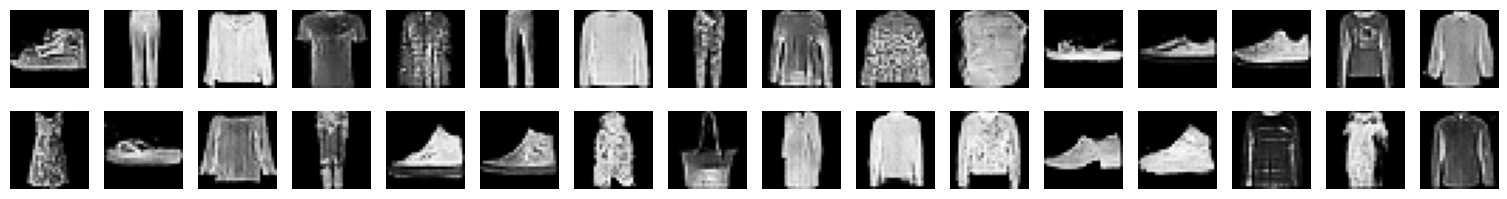

[231/250][150/469]	Loss_D: 0.3631	Loss_G: 8.8615	D(x): 5.5359	D(G(z)): -3.7887 / -8.8601
[231/250][300/469]	Loss_D: 0.0737	Loss_G: 6.3993	D(x): 6.0820	D(G(z)): -5.0790 / -6.3889
[231/250][450/469]	Loss_D: 0.0537	Loss_G: 6.2694	D(x): 5.5037	D(G(z)): -5.6142 / -6.2585
Potential mode collapse detected: Loss_D = 0.0083 and Loss_G = 8.5274.


AttributeError: 'NoneType' object has no attribute 'seek'. You can only torch.load from a file that is seekable. Please pre-load the data into a buffer like io.BytesIO and try to load from it instead.

In [27]:
Utils.cGAN_train(netD, netG, optimizerD, optimizerG, criterion, dataloader,
                EPOCH_NUM, X_DIM, LATENT_DIM, viz_noise, viz_labels, device)

## Sample fake images

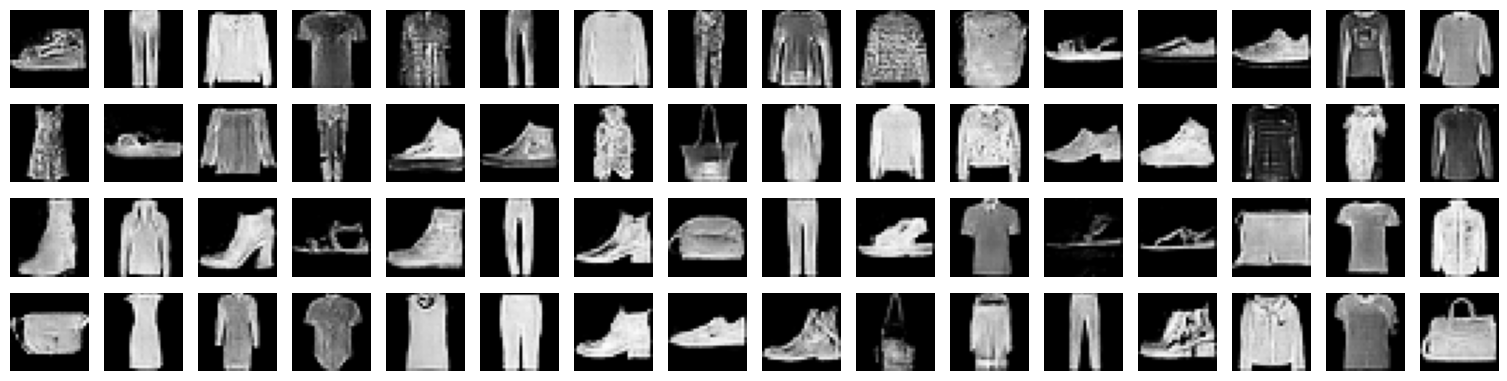

In [28]:
Utils.cgan_plot_fake(netG, viz_noise, viz_labels, X_DIM, cnt=64)

## Saving the model

In [30]:
class CGANExportWrapper(nn.Module):
    def __init__(self, netG, upsample_size=56):
        super().__init__()
        self.netG = netG
        self.upsample = nn.Upsample(size=upsample_size, mode='nearest')

    def forward(self, noise, labels):
        img = self.netG(noise, labels)
        return self.upsample(img)

model = CGANExportWrapper(netG, upsample_size=56).to(device)
dummy_noise = torch.randn(1, LATENT_DIM, 1, 1, device=device)
dummy_labels = torch.randint(0, NUM_CLASSES, (1,), device=device)
Utils.save_model(model, dummy_noise, dummy_labels=dummy_labels, name='cGAN_Fashion_MNIST')